### Impoprt Section

In [1]:
import sys
import os
root_dir = os.getcwd().replace('/notebooks','')
sys.path.insert(1, root_dir)
import pandas as pd
import ast
import numpy as np
from datetime import datetime as dt
import glob
from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar
import os
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar

from zipline.api import (order, 
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol, order_value
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt

import quantstats as qs
import pyfolio as pf
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission

In [2]:
bundle = 'snp500'
calendar_name = 'NYSE'
calendar = get_calendar(calendar_name)
bundle_data = bundles.load(bundle)
sids = bundle_data.asset_finder.sids
assets = bundle_data.asset_finder.retrieve_all(sids)
tickers = [coin.symbol for coin in assets]

In [3]:
data = pd.read_csv('price_by_prphet_etna.csv',index_col=0)
data

AAPL        ABBV        ADSK        ALGN         BIO  \
timestamp                                                                
2018-04-11   41.732859   85.900736  126.661090  246.951419  243.326728   
2018-04-12   41.815973   85.164389  126.311890  252.615826  241.657583   
2018-04-13   41.825633   86.838710  127.299707  255.518451  242.186950   
2018-04-14   42.296707   85.677487  126.364541  253.965214  241.796903   
2018-04-15   42.498866   85.840430  126.241772  253.905744  241.935796   
...                ...         ...         ...         ...         ...   
2023-06-25  186.302304  137.820344  212.227103  336.500022  369.344761   
2023-06-26  187.855436  138.097849  214.137110  339.771669  366.009280   
2023-06-27  187.441287  136.849578  211.489144  338.518983  363.822555   
2023-06-28  187.625707  135.751698  210.402367  338.767067  364.122452   
2023-06-29  189.771072  134.067988  211.888500  342.034311  361.372604   

                  GRMN       INCY        MDT        MSFT         TEL  
timestamp                                                             
2018-04-11   58.318981  74.904841  77.828607   89.893124   96.062725  
2018-04-12   58.142143  71.875594  77.778862   89.690405   95.733085  
2018-04-13   58.496782  70.264930  77.684116   90.149816   96.294387  
2018-04-14   58.612330  71.204426  78.165117   90.183361   96.297788  
2018-04-15   58.705765  70.272448  78.198413   90.818295   96.381729  
...                ...        ...        ...         ...         ...  
2023-06-25  105.128115  62.482658  88.803921  338.756388  136.535530  
2023-06-26  105.591094  62.645155  90.153836  341.794632  137.793509  
2023-06-27  104.827779  61.813481  89.588241  338.799850  137.225851  
2023-06-28  103.861208  61.659001  89.434994  338.996138  137.138534  
2023-06-29  103.770441  61.715472  88.606692  343.135290  137.634602  

[1906 rows x 10 columns]

In [4]:
returns = data.pct_change()
returns=returns[1:]

In [5]:
returns.index=pd.to_datetime(returns.index)

In [6]:
returns

AAPL      ABBV      ADSK      ALGN       BIO      GRMN  \
timestamp                                                                
2018-04-12  0.001992 -0.008572 -0.002757  0.022937 -0.006860 -0.003032   
2018-04-13  0.000231  0.019660  0.007820  0.011490  0.002191  0.006100   
2018-04-14  0.011263 -0.013372 -0.007346 -0.006079 -0.001611  0.001975   
2018-04-15  0.004780  0.001902 -0.000972 -0.000234  0.000574  0.001594   
2018-04-16  0.001592 -0.008020  0.007284 -0.005295  0.000568 -0.002659   
...              ...       ...       ...       ...       ...       ...   
2023-06-25  0.001517  0.000816  0.001668  0.003519  0.001310 -0.001570   
2023-06-26  0.008337  0.002014  0.009000  0.009723 -0.009031  0.004404   
2023-06-27 -0.002205 -0.009039 -0.012366 -0.003687 -0.005975 -0.007229   
2023-06-28  0.000984 -0.008023 -0.005139  0.000733  0.000824 -0.009221   
2023-06-29  0.011434 -0.012403  0.007063  0.009645 -0.007552 -0.000874   

                INCY       MDT      MSFT       TEL  
timestamp                                           
2018-04-12 -0.040441 -0.000639 -0.002255 -0.003432  
2018-04-13 -0.022409 -0.001218  0.005122  0.005863  
2018-04-14  0.013371  0.006192  0.000372  0.000035  
2018-04-15 -0.013089  0.000426  0.007040  0.000872  
2018-04-16 -0.033531 -0.000537  0.006516 -0.002322  
...              ...       ...       ...       ...  
2023-06-25  0.002943  0.006468  0.002278  0.002533  
2023-06-26  0.002601  0.015201  0.008969  0.009214  
2023-06-27 -0.013276 -0.006274 -0.008762 -0.004120  
2023-06-28 -0.002499 -0.001711  0.000579 -0.000636  
2023-06-29  0.000916 -0.009262  0.012210  0.003617  

[1905 rows x 10 columns]

# Bactest on single asset strategy

### ETNA Prophet

lets try with AAPL only with predicted and current SMA

In [7]:
AAPL =pd.read_csv('AAPL_etna_prophet.csv',index_col=0)
AAPL

AAPL
timestamp             
2018-04-11   41.732859
2018-04-12   41.815973
2018-04-13   41.825633
2018-04-14   42.296707
2018-04-15   42.498866
...                ...
2023-06-25  186.302311
2023-06-26  187.855437
2023-06-27  187.441287
2023-06-28  187.625707
2023-06-29  189.771070

[1906 rows x 1 columns]

In [8]:
import pandas as pd

def initialize(context):
    # Load the price dataframe
    price_df = pd.read_csv('AAPL_etna_prophet.csv', index_col=0, parse_dates=True)

    # Store the price dataframe
    context.price_df = price_df

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i=0

def handle_data(context, data):
    asset = symbol('AAPL')
    pricedic = {}
    # Get the current date
    current_date = context.get_datetime().strftime('%Y-%m-%d')

    # Calculate the 7-day SMA of the predicted price for the current date
    predicted_price_history = context.price_df.loc[:current_date, 'AAPL']
    sma_7_days = predicted_price_history.tail(7).mean()
    real_price_history = data.history(symbol('AAPL'), 'price', bar_count=7, frequency='1d')
    real_sma_7_days = real_price_history.mean()
    # Get the current price of AAPL
    
    if context.i%7 ==0:
        # Buy if current price is above the 7-day SMA, sell if below
        if real_sma_7_days > sma_7_days :
            order_value(symbol('AAPL'), 1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Buy AAPL')
        elif real_sma_7_days < sma_7_days :
            order_value(symbol('AAPL'), -1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Sell AAPL')
    context.i = context.i + 1    
    record(PRI=pricedic)

In [9]:
start = '2018-04-20'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start),
    end=pd.Timestamp(end),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL


[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-23   2018-04-23
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       98.0%

Cumulative Return          63.92%       1.52%
Active Return              0.0%         -62.4%
CAGR﹪                     6.8%         0.2%

Sharpe                     0.55         0.3
Prob. Sharpe Ratio         89.36%       75.36%
Smart Sharpe               0.52         0.28
Sortino                    0.77         0.45
Smart Sortino              0.73         0.43
Sortino/√2                 0.54         0.32
Smart Sortino/√2           0.52         0.3
Omega                      1.06         1.06

Max Drawdown               -33.92%      -2.51%
Longest DD Days            541          1192
Volatility (ann.)          21.42%       0.99%
R^2                        0.02         0.02
Information Ratio       

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-03-24  2022-11-09  2023-06-28  1192     -2.510768         -2.426075
2  2018-11-26  2018-12-03  2018-12-06    11     -0.327881         -0.246114
3  2018-07-05  2018-10-03  2018-11-01   120     -0.309317         -0.269562
4  2019-06-04  2019-07-31  2019-10-31   150     -0.262674         -0.236881
5  2018-12-26  2019-01-02  2019-01-02     8     -0.256651         -0.252412

Slippage: 103.12399999999957
Slippage Lost: -14.18199999996564
Total Commission: 6.441000000000001


Average Long Exposure = 1439.9050260336908
Average Short Exposure = -1137.6669264931088
Average Net Leverage = 0.0029809850011054727
Average Gross Leverage = 0.025490364421043937
Max Leverage = 0.0757972209830316



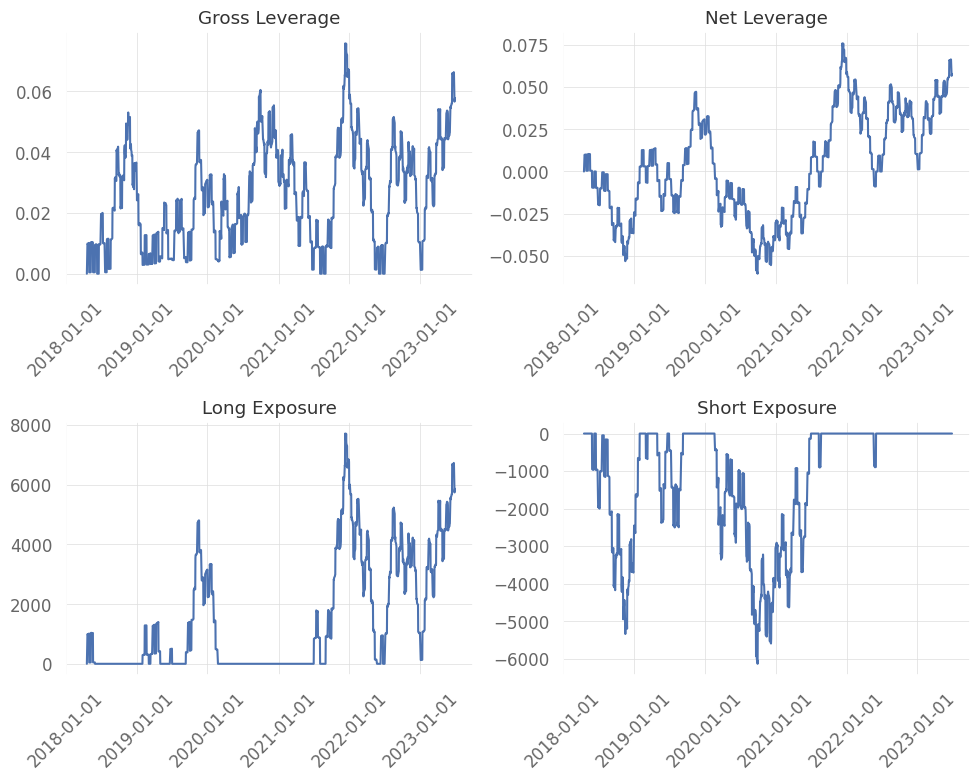

AAPL





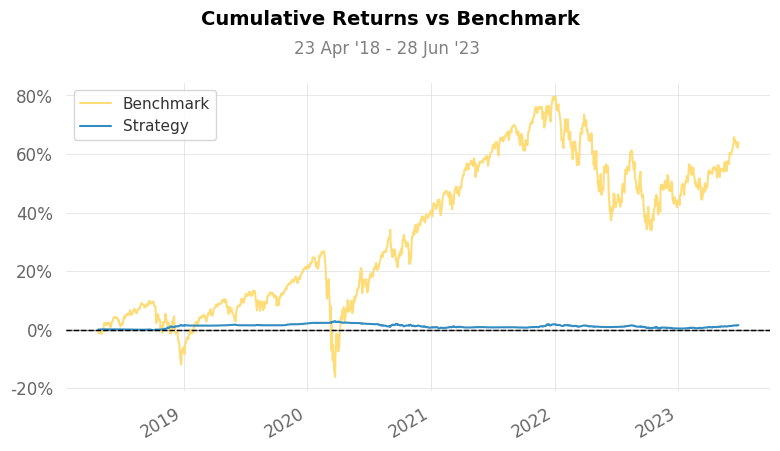

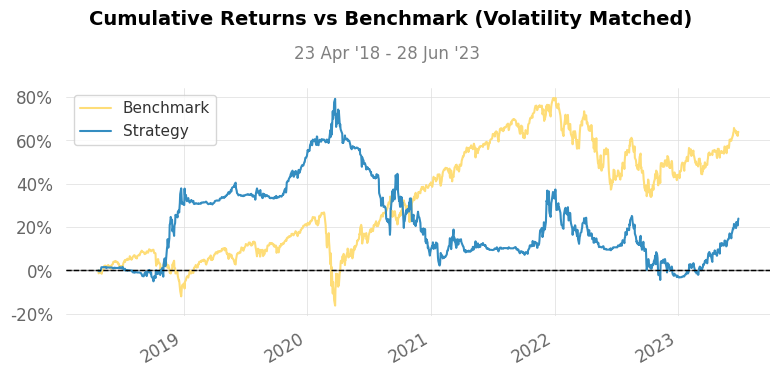

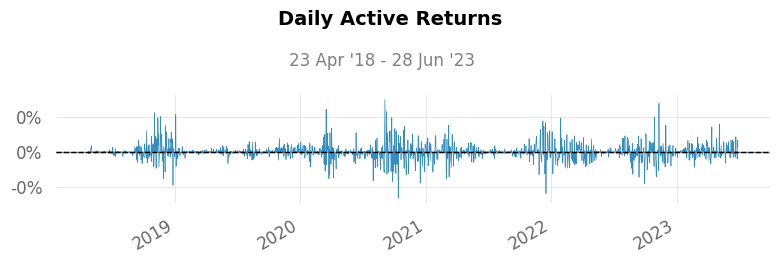

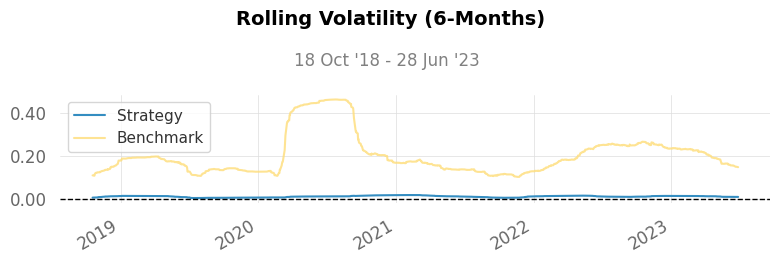

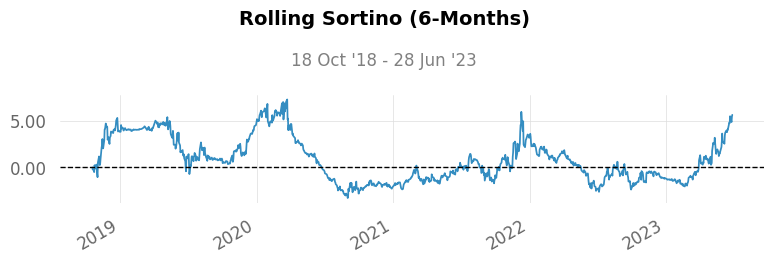

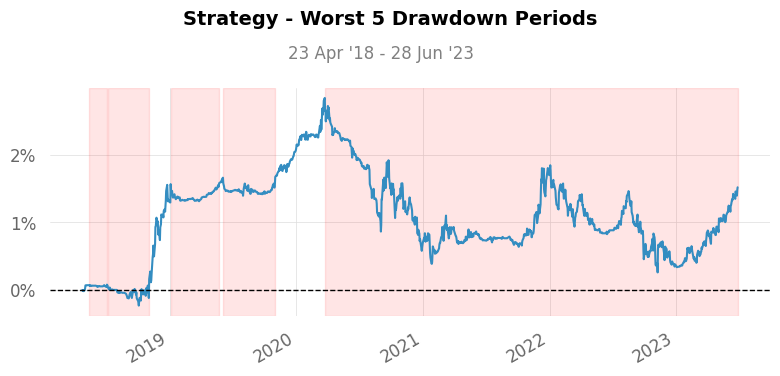

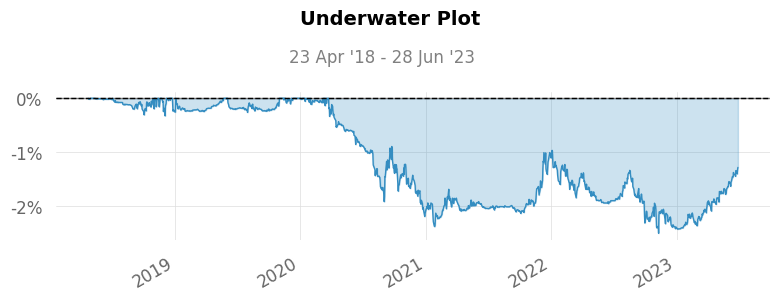

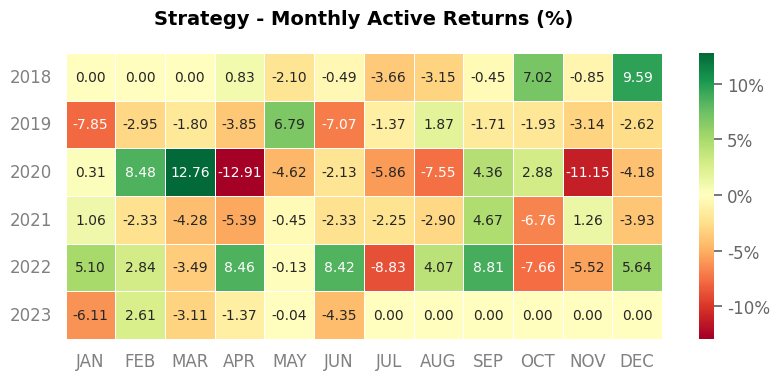

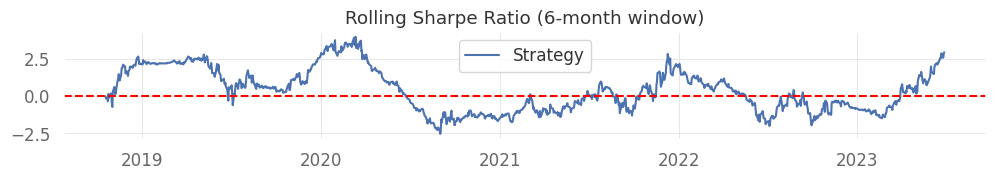

[*********************100%***********************]  1 of 1 completed


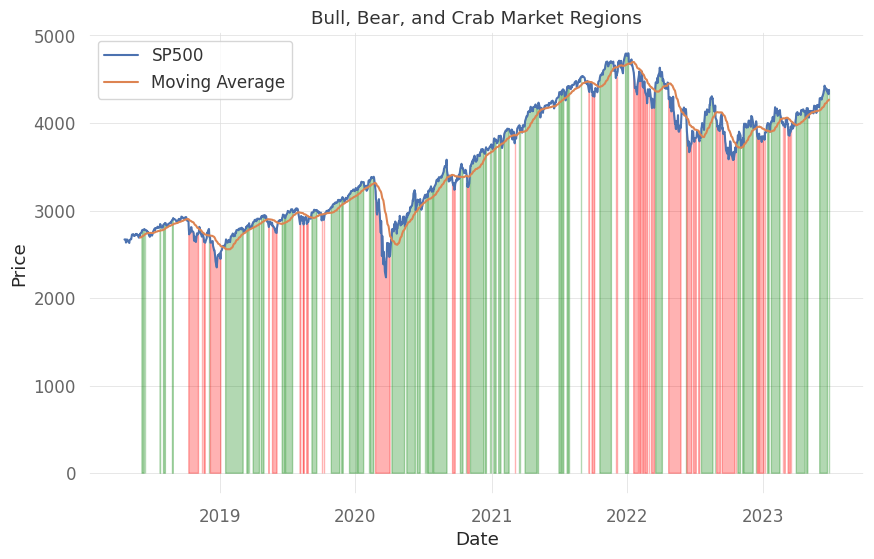

Total Trades: 187
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





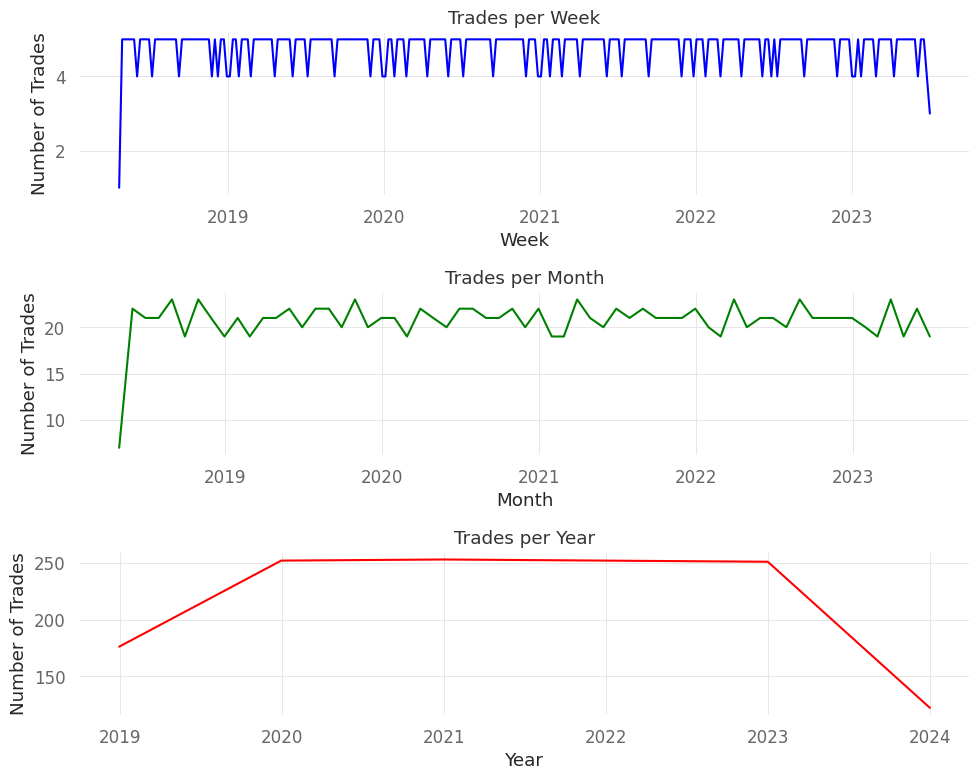

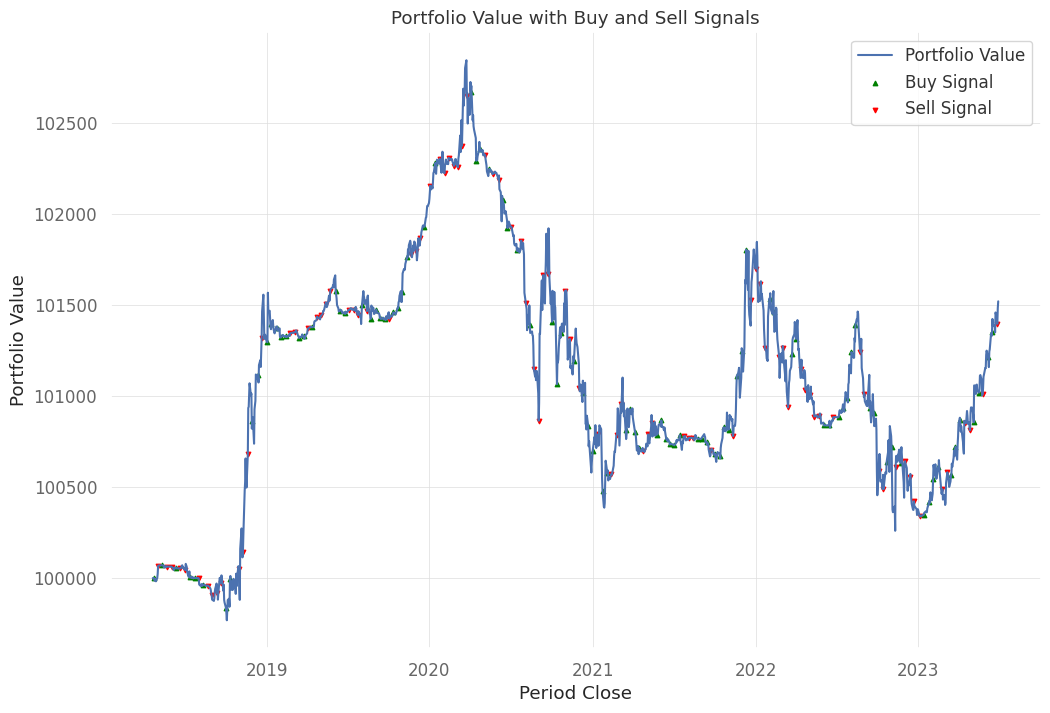

In [10]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)

### ETNA Catboost

In [11]:
AAPL =pd.read_csv('apple_by_catboost_etna.csv',index_col=0)
AAPL

target
timestamp             
2018-04-11   43.404190
2018-04-12   43.321320
2018-04-13   43.432711
2018-04-14   43.567824
2018-04-15   43.617199
...                ...
2023-06-25  185.247757
2023-06-26  186.712540
2023-06-27  185.203133
2023-06-28  186.750290
2023-06-29  187.109371

[1906 rows x 1 columns]

In [12]:
import pandas as pd

def initialize(context):
    # Load the price dataframe
    price_df = pd.read_csv('apple_by_catboost_etna.csv', index_col=0, parse_dates=True)

    # Store the price dataframe
    context.price_df = price_df

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i = 0

def handle_data(context, data):
    asset = symbol('AAPL')

    pricedic = {}
    # Get the current date
    current_date = context.get_datetime().strftime('%Y-%m-%d')

    # Calculate the 7-day SMA of the predicted price for the current date
    predicted_price_history = context.price_df.loc[:current_date, 'target']
    sma_7_days = predicted_price_history.tail(7).mean()
    real_price_history = data.history(symbol('AAPL'), 'price', bar_count=7, frequency='1d')
    real_sma_7_days = real_price_history.mean()
    # Get the current price of AAPL
    

    if context.i%7 ==0:
        # Buy if current price is above the 7-day SMA, sell if below
        if real_sma_7_days > sma_7_days :
            order_value(symbol('AAPL'), 1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Buy AAPL')
        elif real_sma_7_days < sma_7_days :
            order_value(symbol('AAPL'), -1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Sell AAPL')
    context.i = context.i + 1 
        
    record(PRI=pricedic)

In [13]:
start = '2018-04-20'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start),
    end=pd.Timestamp(end),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Se

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-23   2018-04-23
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          63.92%       22.79%
Active Return              0.0%         -41.13%
CAGR﹪                     6.8%         2.77%

Sharpe                     0.55         0.68
Prob. Sharpe Ratio         89.36%       94.03%
Smart Sharpe               0.53         0.66
Sortino                    0.77         1.0
Smart Sortino              0.74         0.97
Sortino/√2                 0.54         0.71
Smart Sortino/√2           0.52         0.68
Omega                      1.14         1.14

Max Drawdown               -33.92%      -9.55%
Longest DD Days            541          534
Volatility (ann.)          21.42%       6.06%
R^2                        0.32         0.32
Information Ratio   

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-01-04  2023-01-05  2023-06-21   534     -9.548192         -8.889490
2  2021-01-27  2021-03-08  2021-07-13   168     -5.759151         -5.003659
3  2020-09-02  2020-09-18  2020-12-24   114     -5.382629         -5.291785
4  2021-09-08  2021-10-04  2021-11-17    71     -2.977564         -2.691449
5  2019-01-04  2020-03-23  2020-06-08   522     -2.778308         -2.587846

Slippage: 103.12400000000925
Slippage Lost: 13.118000000034485
Total Commission: 6.441000000000001


Average Long Exposure = 17941.05684839204
Average Short Exposure = -1003.1504793261869
Average Net Leverage = 0.14768442725163025
Average Gross Leverage = 0.16760265731249055
Max Leverage = 0.3202039288295417



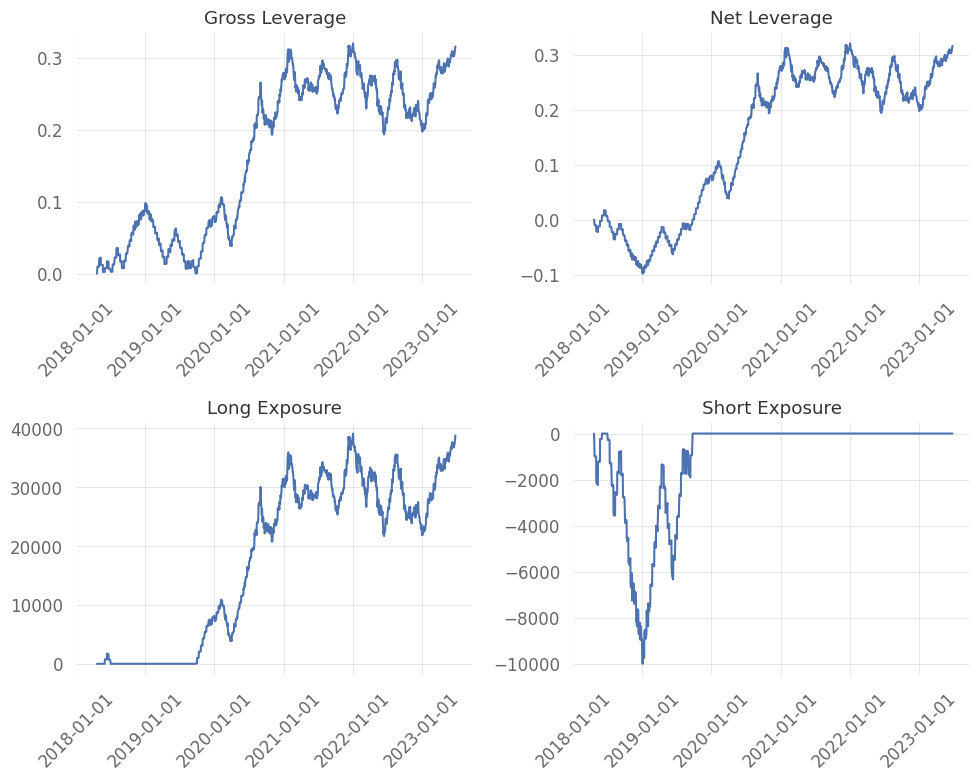

AAPL





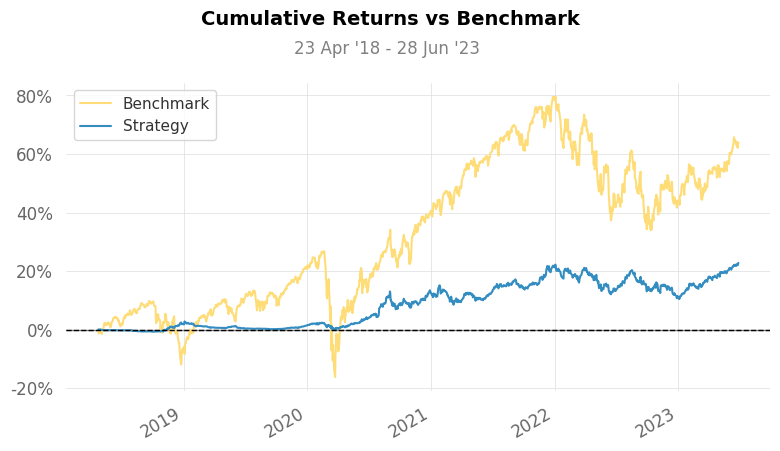

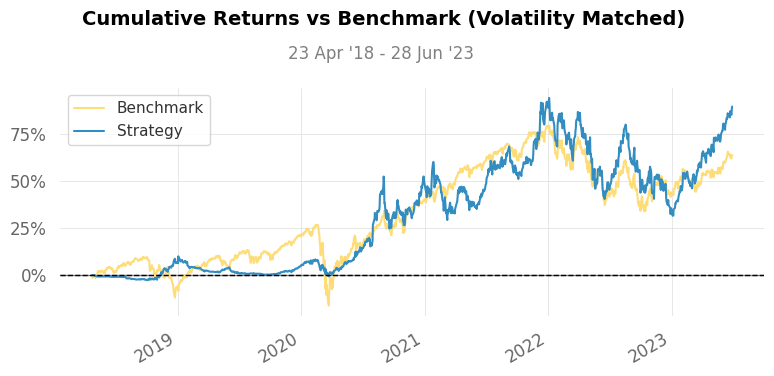

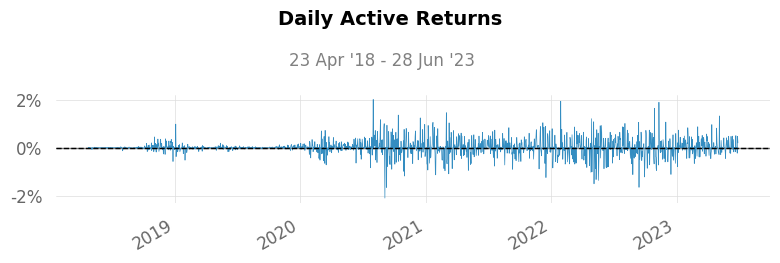

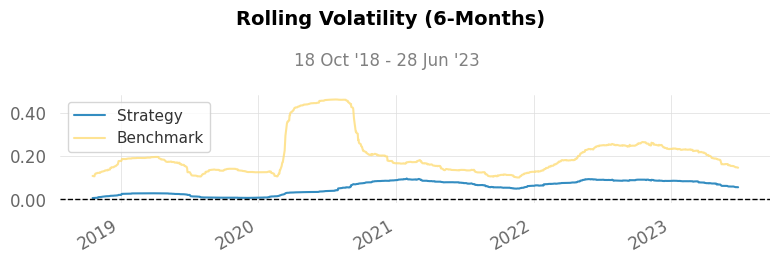

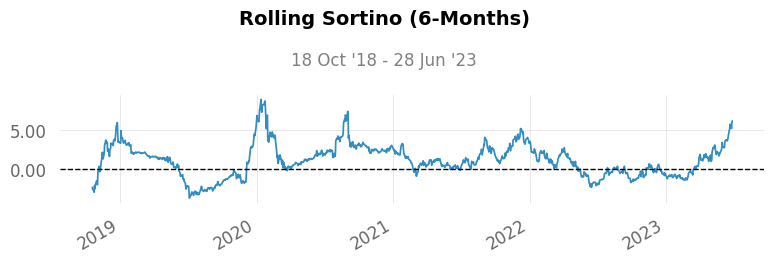

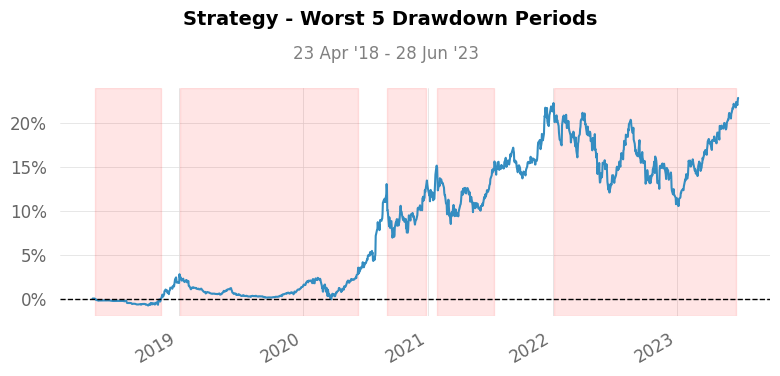

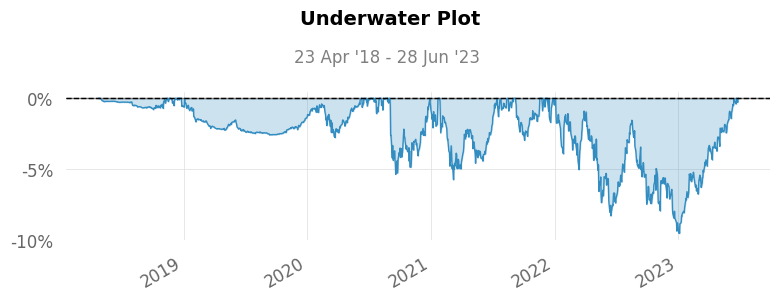

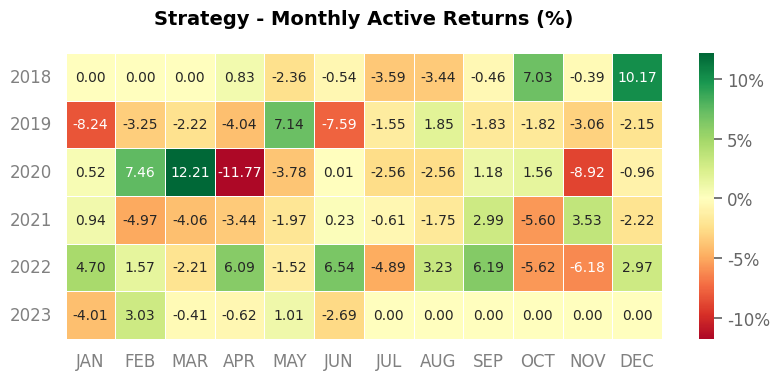

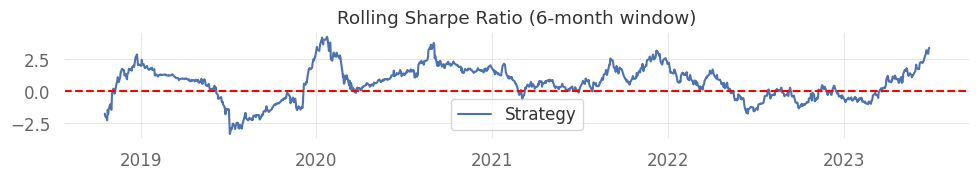

[*********************100%***********************]  1 of 1 completed


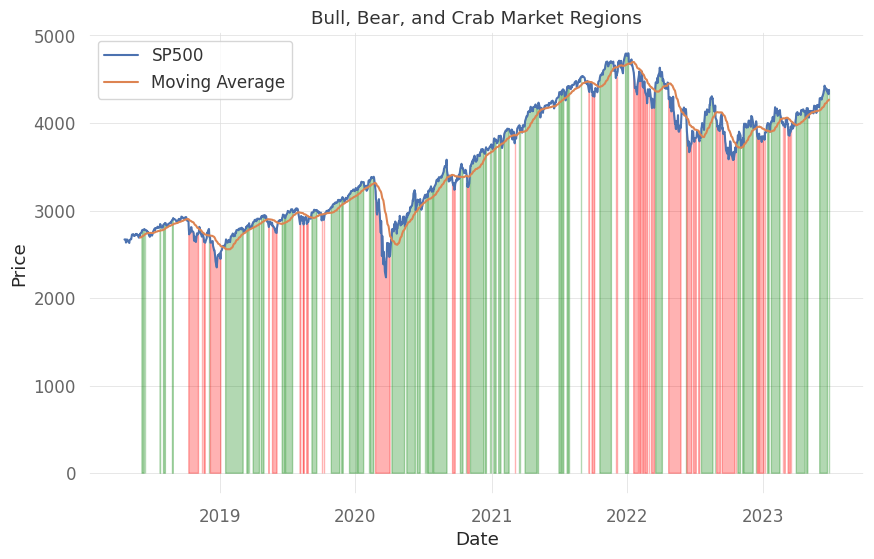

Total Trades: 187
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





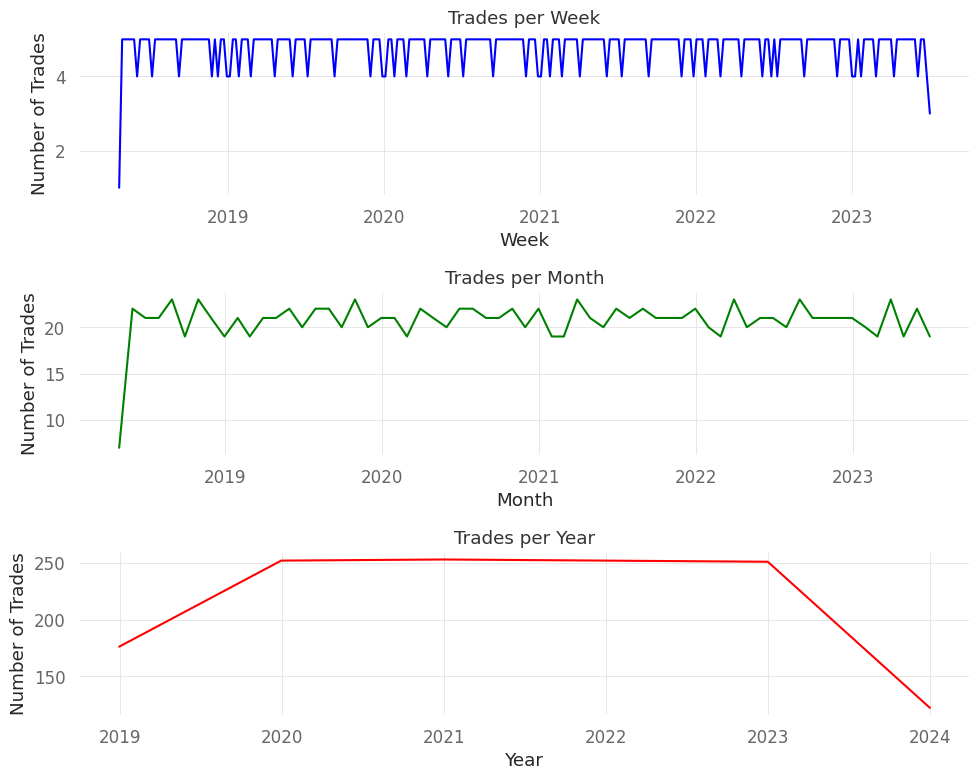

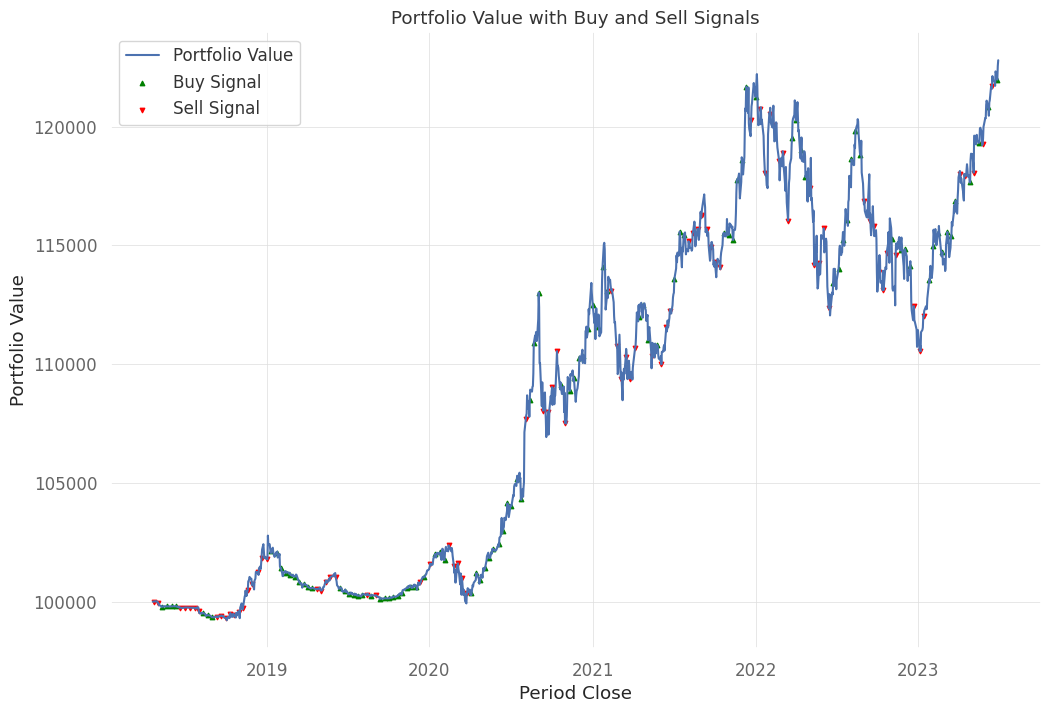

In [14]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)

### ETNA Naive

In [15]:
import pandas as pd

def initialize(context):
    # Load the price dataframe
    price_df = pd.read_csv('apple_by_Naive_etna.csv', index_col=0, parse_dates=True)

    # Store the price dataframe
    context.price_df = price_df

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i = 0

def handle_data(context, data):
    asset = symbol('AAPL')

    pricedic = {}
    # Get the current date
    current_date = context.get_datetime().strftime('%Y-%m-%d')

    # Calculate the 7-day SMA of the predicted price for the current date
    predicted_price_history = context.price_df.loc[:current_date, 'target']
    sma_7_days = predicted_price_history.tail(7).mean()
    real_price_history = data.history(symbol('AAPL'), 'price', bar_count=7, frequency='1d')
    real_sma_7_days = real_price_history.mean()
    # Get the current price of AAPL
    

    if context.i%7 ==0:
        # Buy if current price is above the 7-day SMA, sell if below
        if real_sma_7_days > sma_7_days :
            order_value(symbol('AAPL'), 1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Buy AAPL')
        elif real_sma_7_days < sma_7_days :
            order_value(symbol('AAPL'), -1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Sell AAPL')
    context.i = context.i + 1 
        
    record(PRI=pricedic)

In [16]:
start = '2018-04-20'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start),
    end=pd.Timestamp(end),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy A

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-23   2018-04-23
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          63.92%       20.69%
Active Return              0.0%         -43.23%
CAGR﹪                     6.8%         2.54%

Sharpe                     0.55         0.73
Prob. Sharpe Ratio         89.36%       95.11%
Smart Sharpe               0.53         0.7
Sortino                    0.77         1.06
Smart Sortino              0.74         1.03
Sortino/√2                 0.54         0.75
Smart Sortino/√2           0.52         0.73
Omega                      1.15         1.15

Max Drawdown               -33.92%      -8.68%
Longest DD Days            541          534
Volatility (ann.)          21.42%       5.18%
R^2                        0.37         0.37
Information Ratio   

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-01-04  2023-01-05  2023-06-21   534     -8.675917         -8.089953
2  2020-09-02  2020-09-18  2021-01-21   142     -3.991593         -3.914886
3  2021-01-27  2021-03-08  2021-07-06   161     -3.532542         -3.087515
4  2021-09-08  2021-10-04  2021-11-17    71     -2.529426         -2.295946
5  2020-02-13  2020-03-23  2020-05-08    86     -2.305837         -2.213179

Slippage: 103.12400000000629
Slippage Lost: 27.910000000034287
Total Commission: 6.441000000000001


Average Long Exposure = 15520.040842266462
Average Short Exposure = -683.4640811638592
Average Net Leverage = 0.1307178199685497
Average Gross Leverage = 0.14429381533461633
Max Leverage = 0.2900901957729032



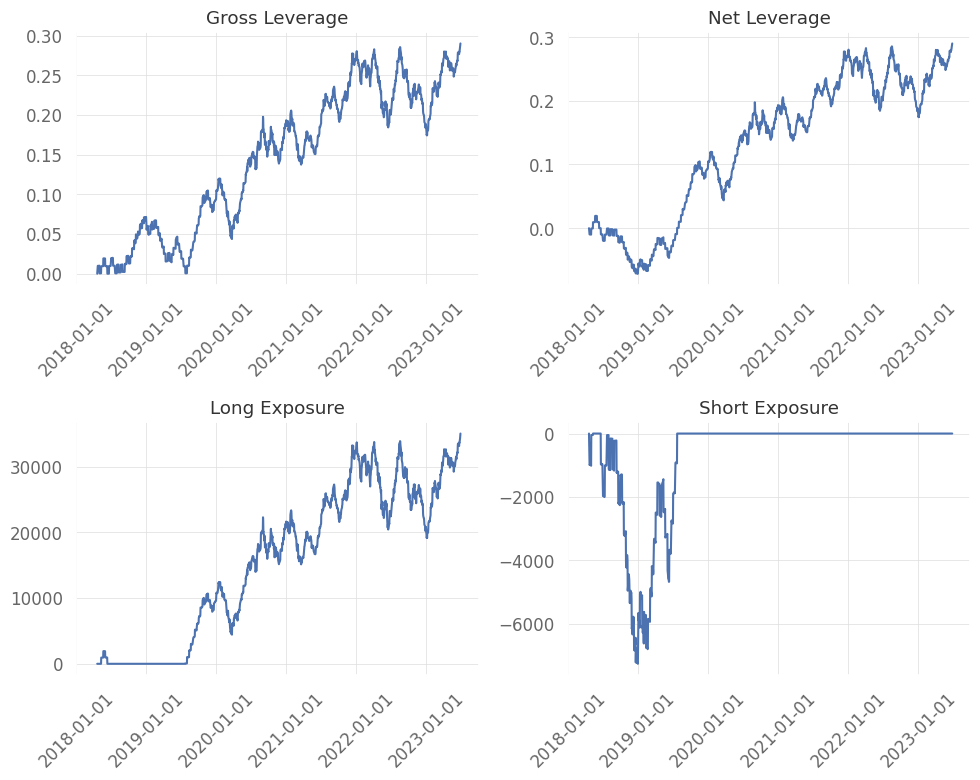

AAPL





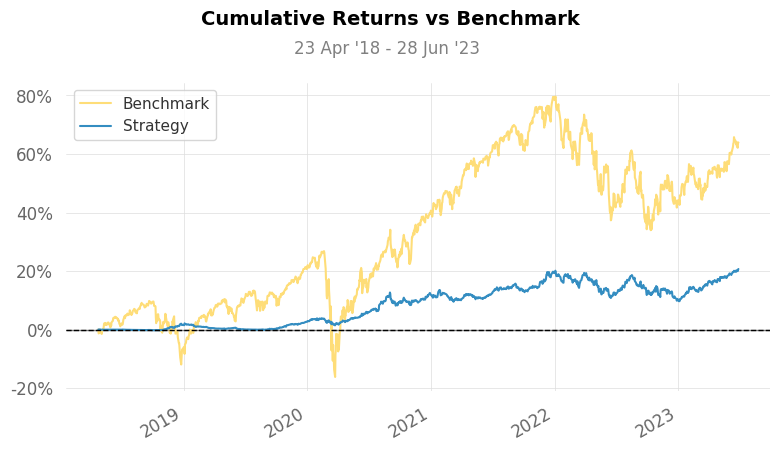

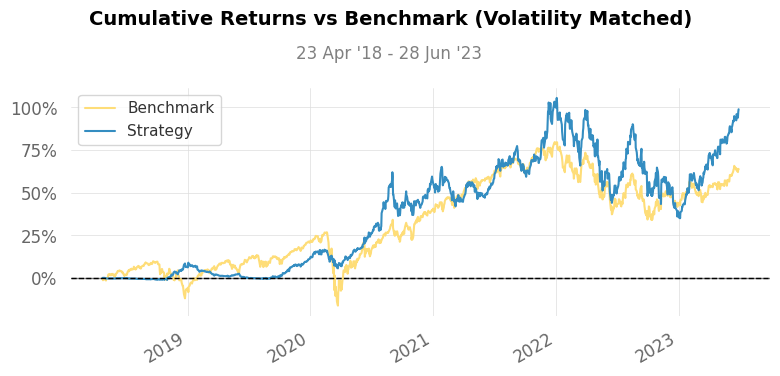

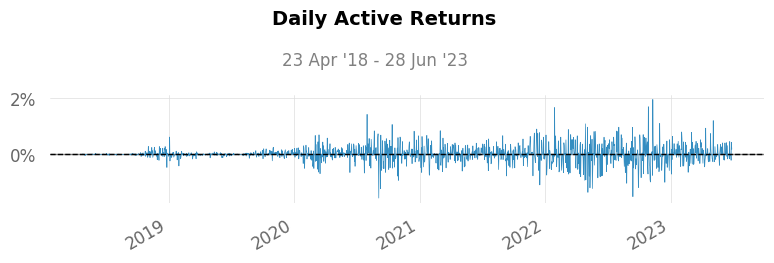

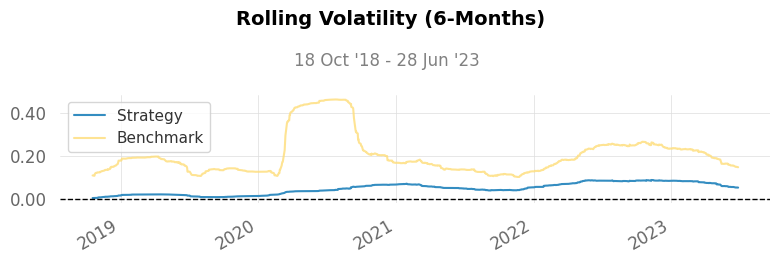

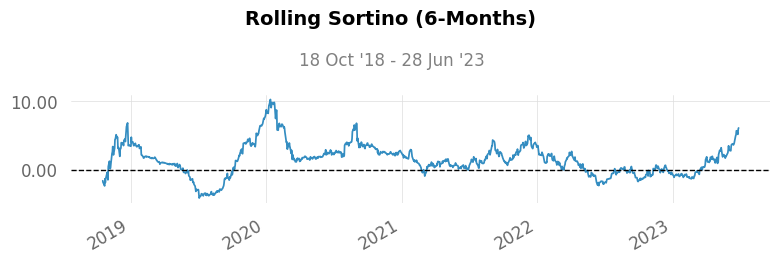

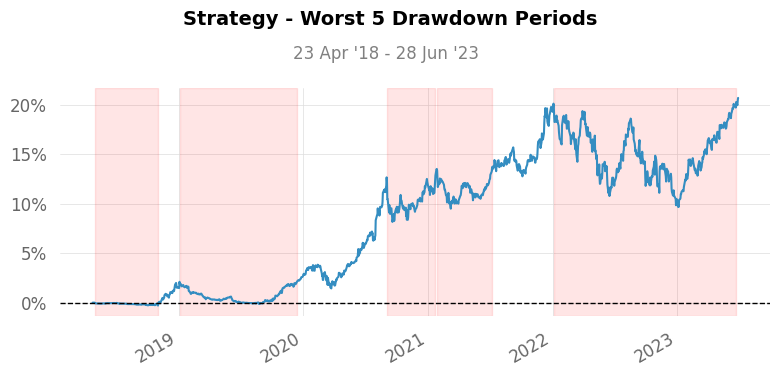

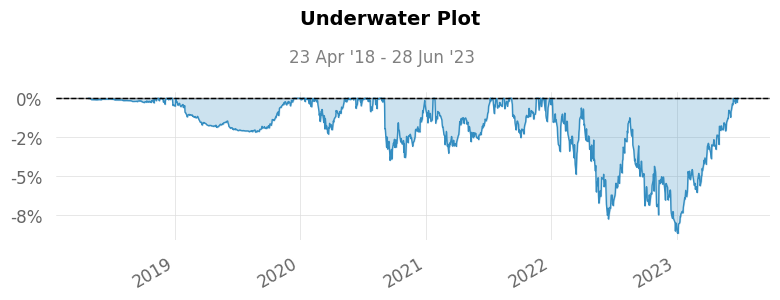

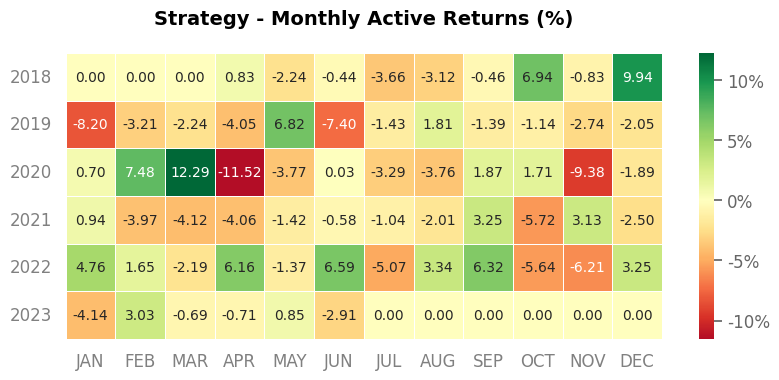

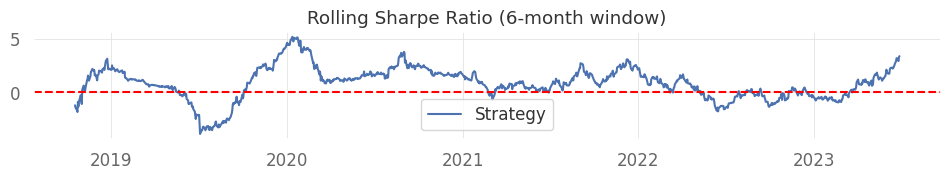

[*********************100%***********************]  1 of 1 completed


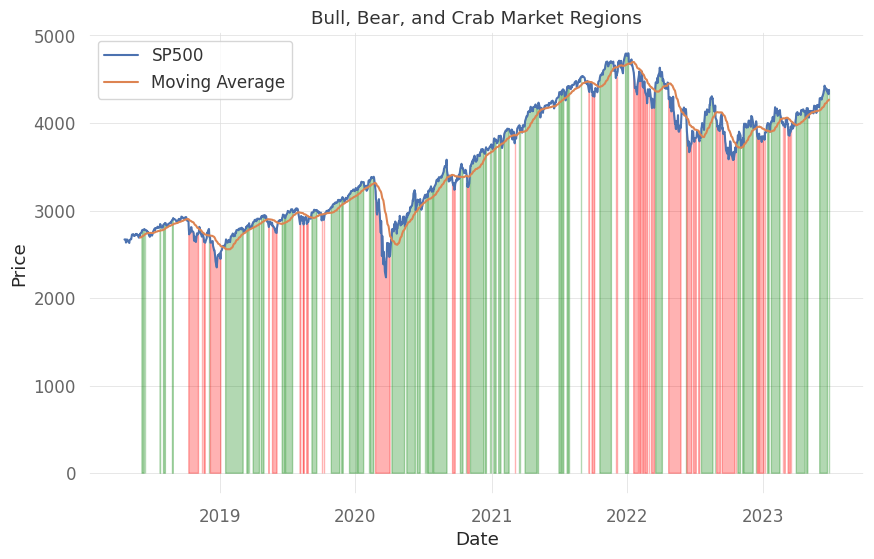

Total Trades: 187
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





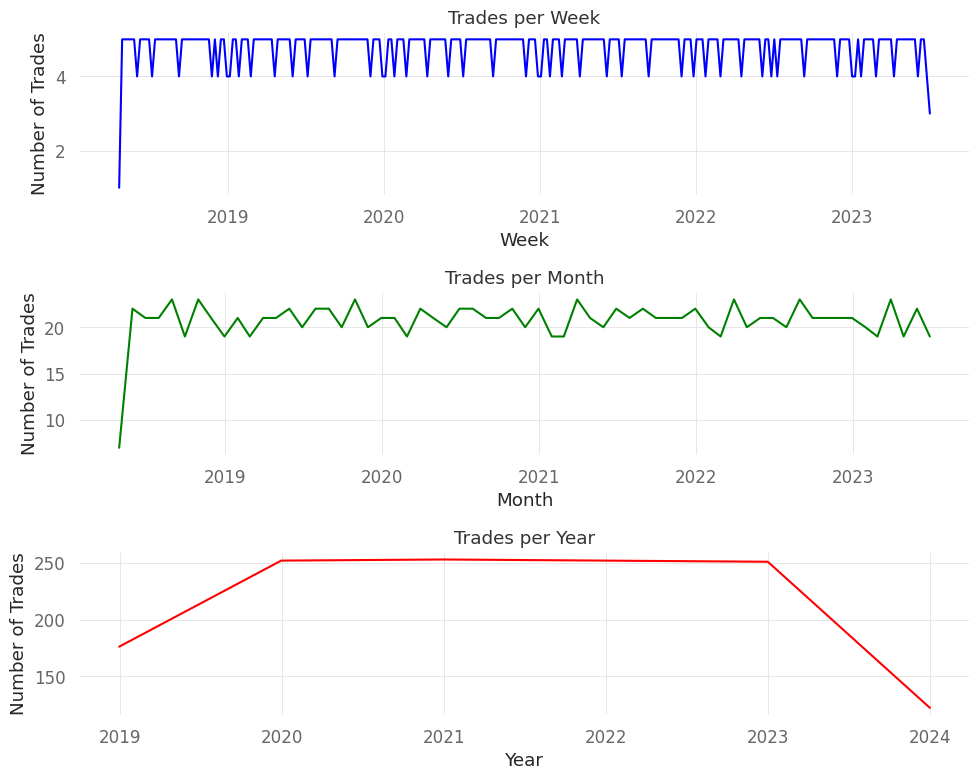

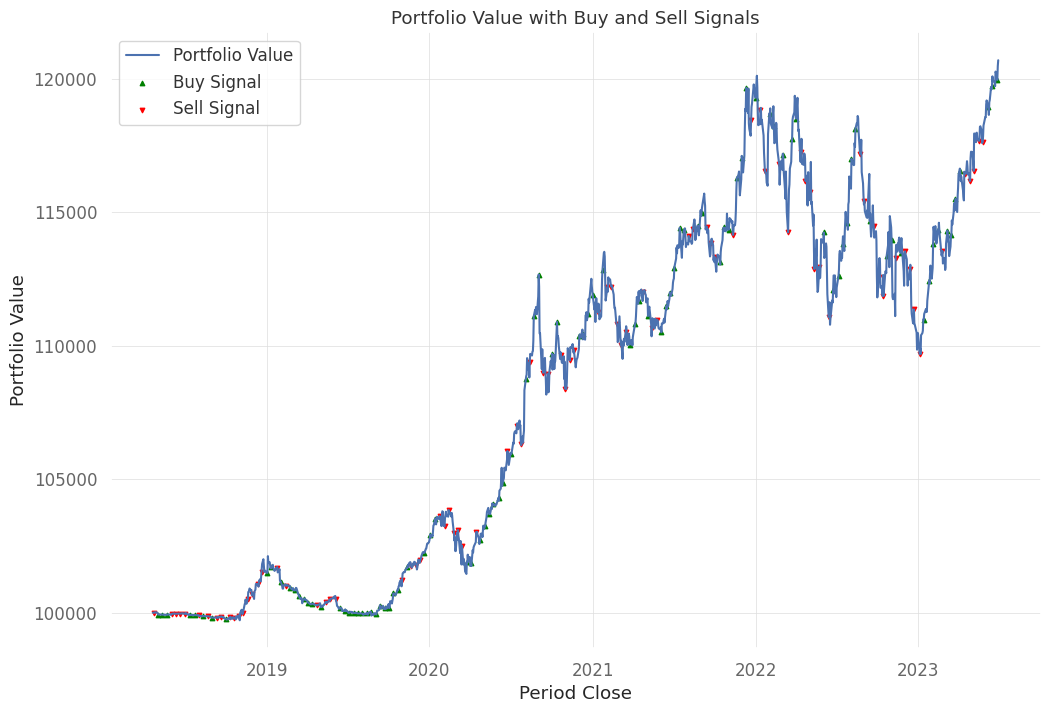

In [17]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)

### ETNA Arima

In [18]:
import pandas as pd

def initialize(context):
    # Load the price dataframe
    price_df = pd.read_csv('apple_by_Arima_etna.csv', index_col=0, parse_dates=True)

    # Store the price dataframe
    context.price_df = price_df

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i = 0

def handle_data(context, data):
    asset = symbol('AAPL')

    pricedic = {}
    # Get the current date
    current_date = context.get_datetime().strftime('%Y-%m-%d')

    # Calculate the 7-day SMA of the predicted price for the current date
    predicted_price_history = context.price_df.loc[:current_date, 'target']
    sma_7_days = predicted_price_history.tail(7).mean()
    real_price_history = data.history(symbol('AAPL'), 'price', bar_count=7, frequency='1d')
    real_sma_7_days = real_price_history.mean()
    # Get the current price of AAPL
    

    if context.i%7 ==0:
        # Buy if current price is above the 7-day SMA, sell if below
        if real_sma_7_days > sma_7_days :
            order_value(symbol('AAPL'), 1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Buy AAPL')
        elif real_sma_7_days < sma_7_days :
            order_value(symbol('AAPL'), -1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Sell AAPL')
    context.i = context.i + 1 
        
    record(PRI=pricedic)

In [19]:
start = '2018-04-20'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start),
    end=pd.Timestamp(end),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
S

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-23   2018-04-23
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          63.92%       27.73%
Active Return              0.0%         -36.19%
CAGR﹪                     6.8%         3.31%

Sharpe                     0.55         0.72
Prob. Sharpe Ratio         89.36%       94.97%
Smart Sharpe               0.53         0.69
Sortino                    0.77         1.06
Smart Sortino              0.73         1.0
Sortino/√2                 0.54         0.75
Smart Sortino/√2           0.52         0.71
Omega                      1.15         1.15

Max Drawdown               -33.92%      -10.59%
Longest DD Days            541          527
Volatility (ann.)          21.42%       6.88%
R^2                        0.4          0.4
Information Ratio   

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-01-04  2023-01-05  2023-06-14   527    -10.588290         -9.809259
2  2021-01-27  2021-03-08  2021-07-13   168     -6.017654         -5.240513
3  2020-09-02  2020-09-18  2020-12-24   114     -5.909133         -5.814062
4  2020-02-13  2020-03-23  2020-06-04   113     -4.106536         -3.921250
5  2021-09-08  2021-10-04  2021-11-17    71     -3.277513         -2.967566

Slippage: 103.12400000000788
Slippage Lost: 14.09800000003446
Total Commission: 6.441000000000001


Average Long Exposure = 21145.004144716695
Average Short Exposure = -562.0384586523736
Average Net Leverage = 0.1751056687192363
Average Gross Leverage = 0.1863011019630557
Max Leverage = 0.34226188367465393



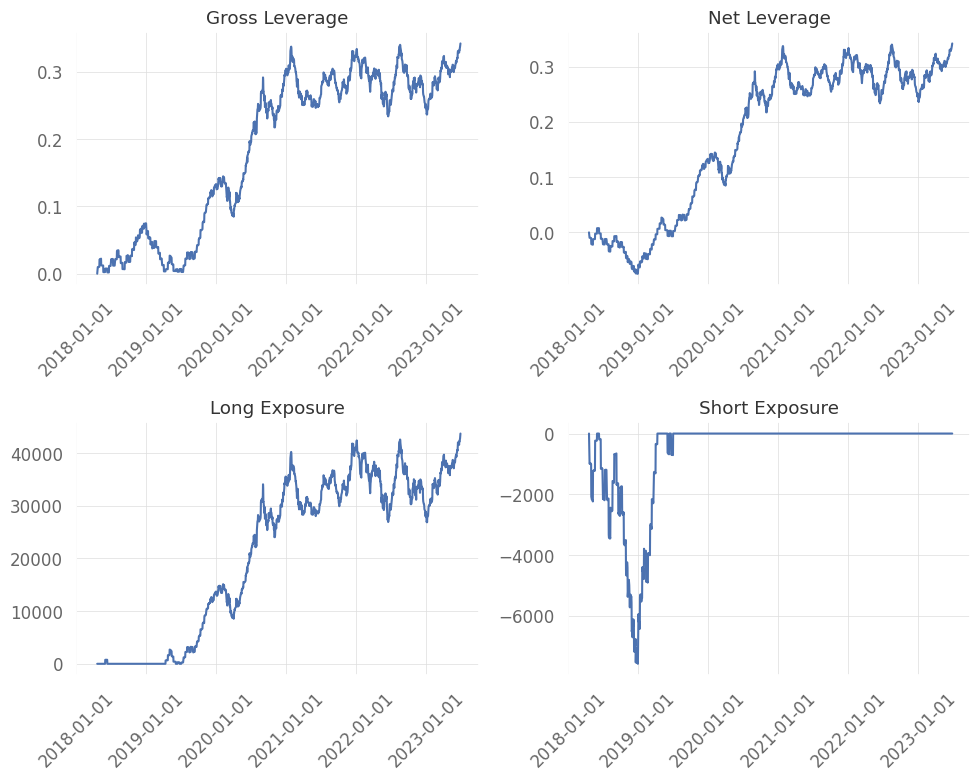

AAPL





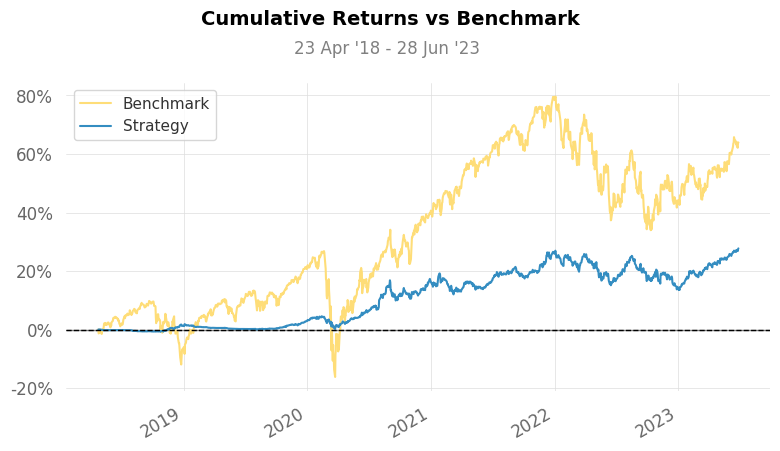

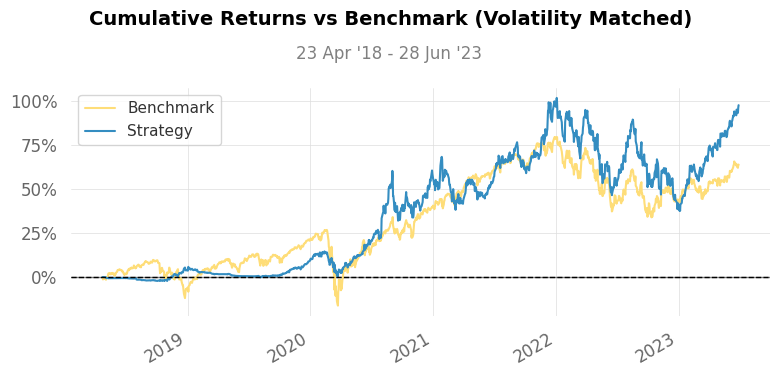

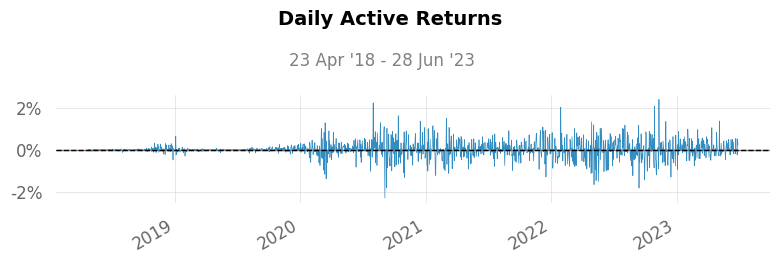

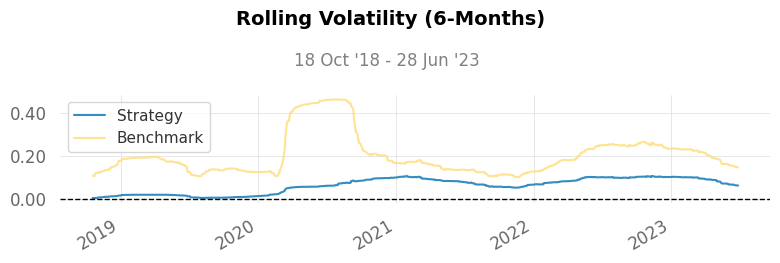

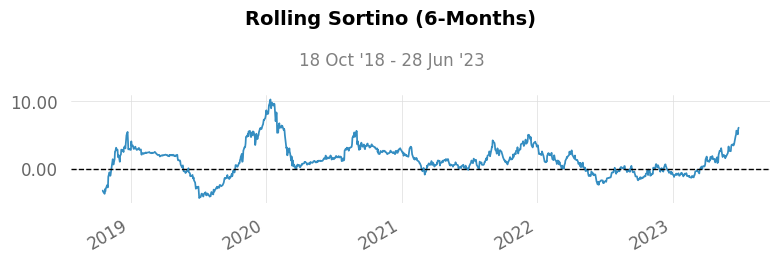

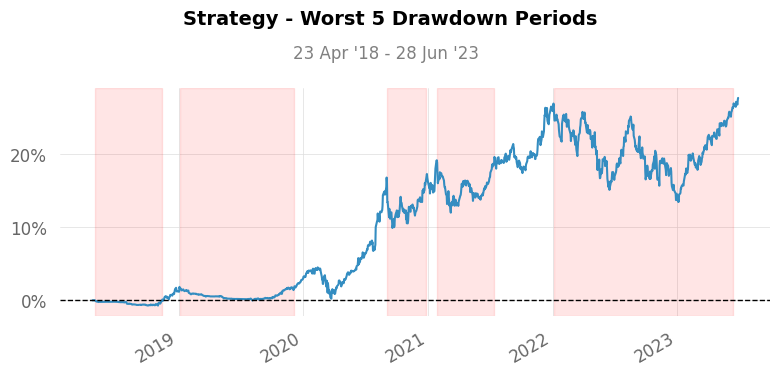

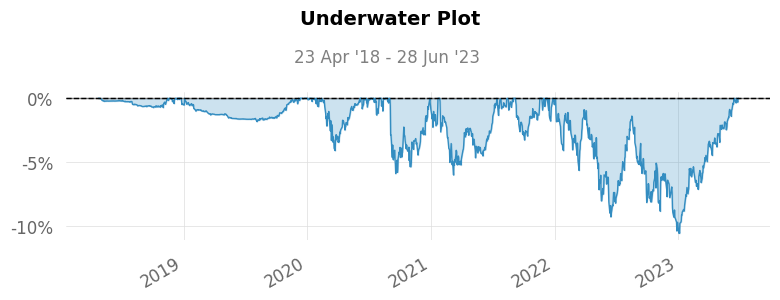

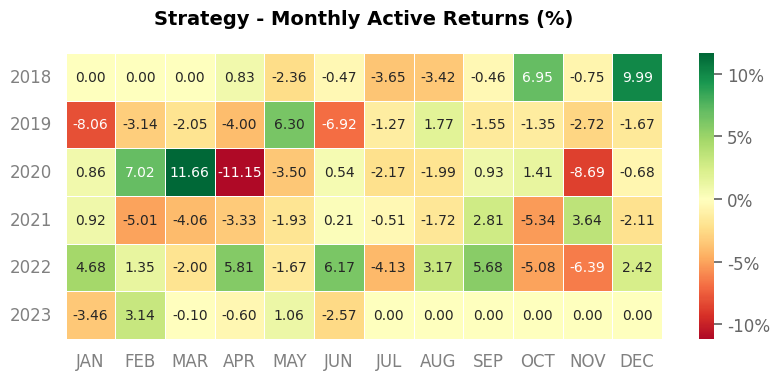

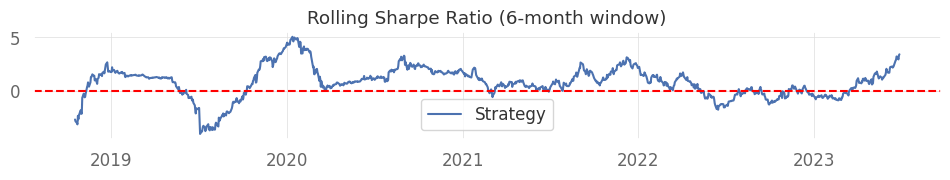

[*********************100%***********************]  1 of 1 completed


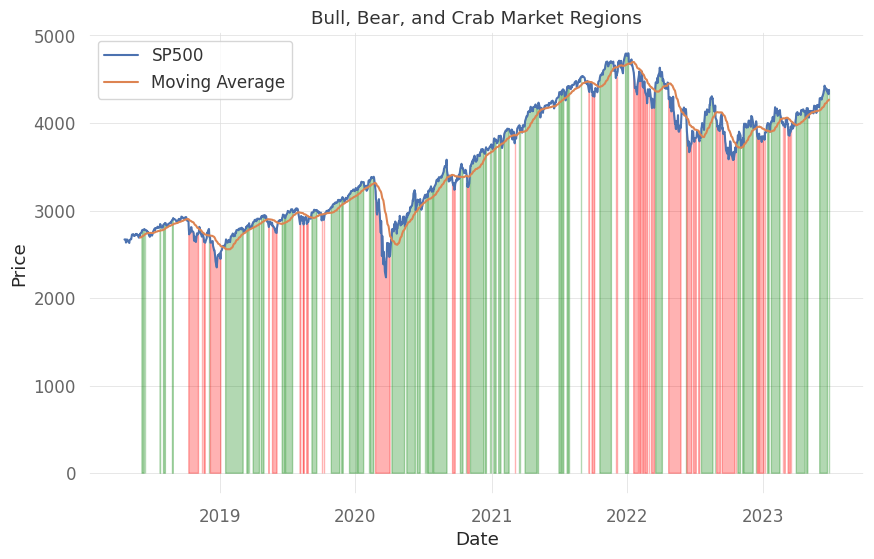

Total Trades: 187
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





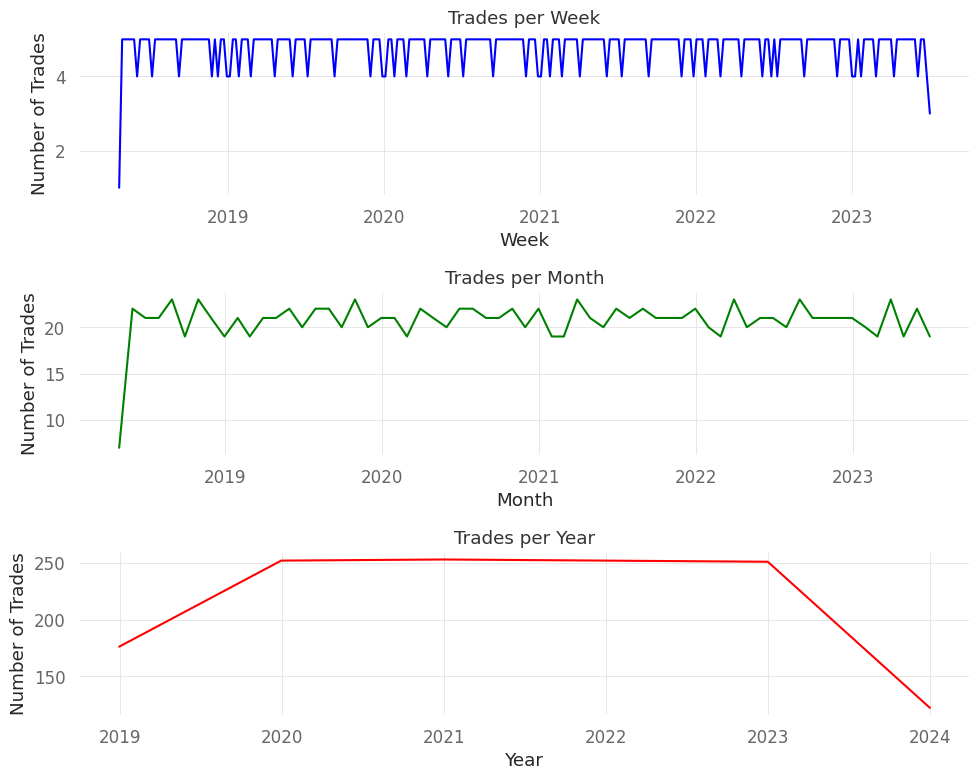

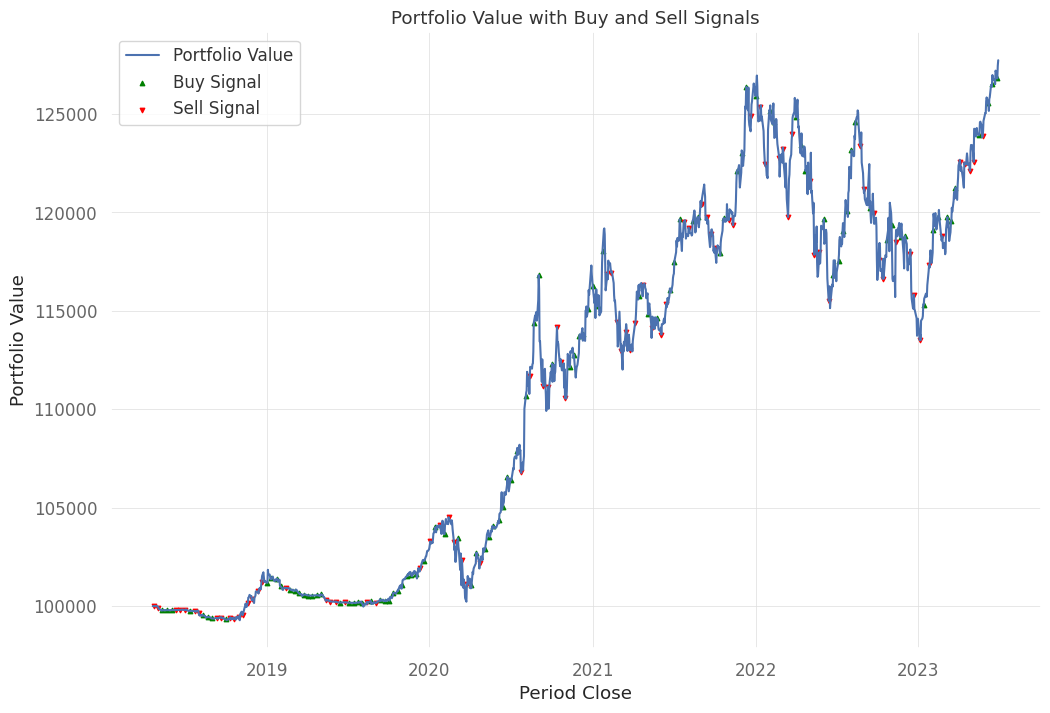

In [20]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)

### ETNA SARIMAX

In [30]:
import pandas as pd

def initialize(context):
    # Load the price dataframe
    price_df = pd.read_csv('apple_by_SArimax_etna.csv', index_col=0, parse_dates=True)

    # Store the price dataframe
    context.price_df = price_df

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i = 0

def handle_data(context, data):
    asset = symbol('AAPL')

    pricedic = {}
    # Get the current date
    current_date = context.get_datetime().strftime('%Y-%m-%d')

    # Calculate the 7-day SMA of the predicted price for the current date
    predicted_price_history = context.price_df.loc[:current_date, 'target']
    sma_7_days = predicted_price_history.tail(7).mean()
    real_price_history = data.history(symbol('AAPL'), 'price', bar_count=7, frequency='1d')
    real_sma_7_days = real_price_history.mean()
    # Get the current price of AAPL
    

    if context.i%7 ==0:
        # Buy if current price is above the 7-day SMA, sell if below
        if real_sma_7_days > sma_7_days :
            order_value(symbol('AAPL'), 1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Buy AAPL')
        elif real_sma_7_days < sma_7_days :
            order_value(symbol('AAPL'), -1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Sell AAPL')
    context.i = context.i + 1 
        
    record(PRI=pricedic)

In [31]:
start = '2018-04-20'
end = '2019-02-04'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start),
    end=pd.Timestamp(end),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL


[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-23   2018-04-23
End Period                 2019-02-04   2019-02-04
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          2.05%        1.11%
Active Return              0.0%         -0.94%
CAGR﹪                     1.8%         0.97%

Sharpe                     0.24         0.67
Prob. Sharpe Ratio         58.4%        72.75%
Smart Sharpe               0.23         0.63
Sortino                    0.33         1.1
Smart Sortino              0.31         1.04
Sortino/√2                 0.24         0.78
Smart Sortino/√2           0.22         0.73
Omega                      1.16         1.16

Max Drawdown               -19.78%      -1.23%
Longest DD Days            137          198
Volatility (ann.)          16.2%        2.12%
R^2                        0.58         0.58
Information Ratio     

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2019-01-04  2019-02-04  2019-02-04    32     -1.225253         -1.071670
2  2018-04-30  2018-10-03  2018-11-13   198     -1.159901         -1.085454
3  2018-12-26  2019-01-02  2019-01-02     8     -0.634842         -0.624464
4  2018-11-26  2018-12-03  2018-12-06    11     -0.541805         -0.354163
5  2018-11-15  2018-11-16  2018-11-16     2     -0.243458         -0.166889

Slippage: 2.879999999998873
Slippage Lost: -1.6639999999921997
Total Commission: 1.8090000000000002


Average Long Exposure = 27.05021105527638
Average Short Exposure = -4445.753623115578
Average Net Leverage = -0.04408898827721564
Average Gross Leverage = 0.04463105498316908
Max Leverage = 0.09087081003333093



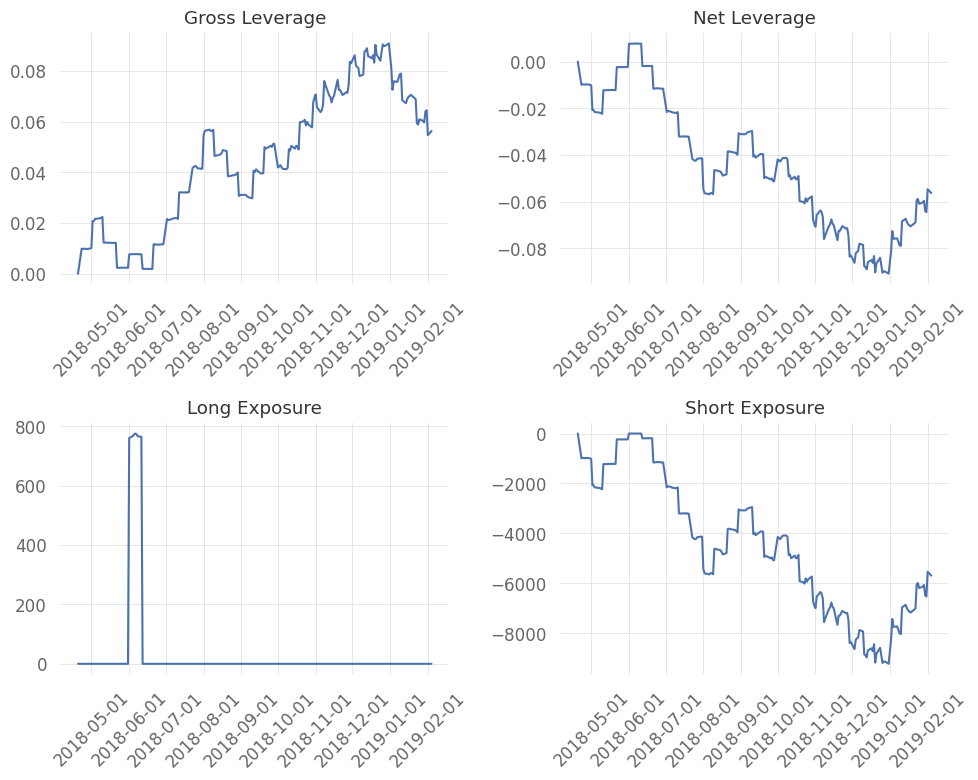

AAPL





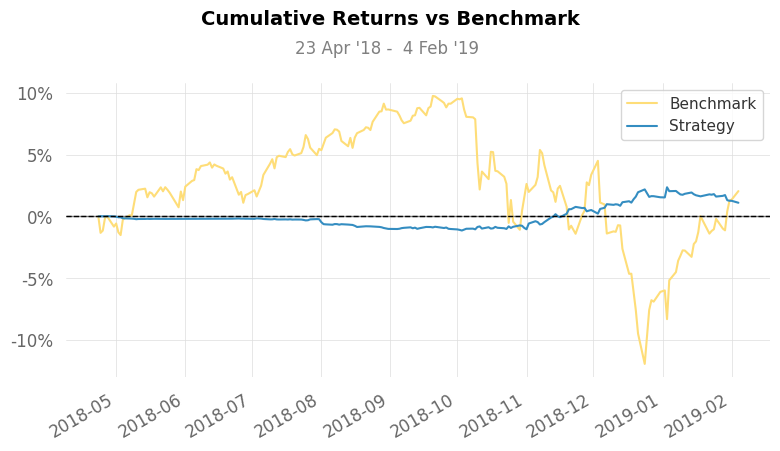

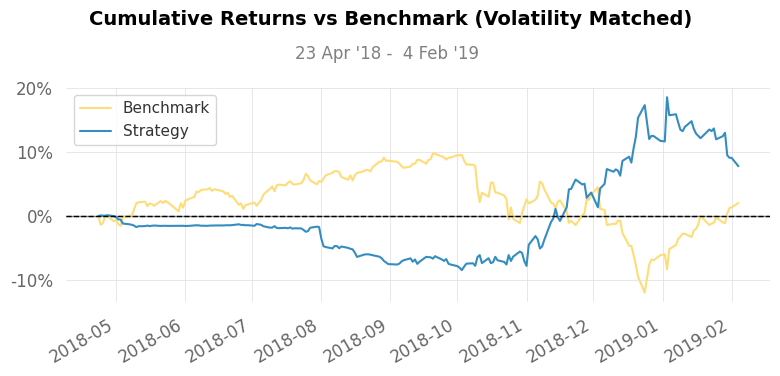

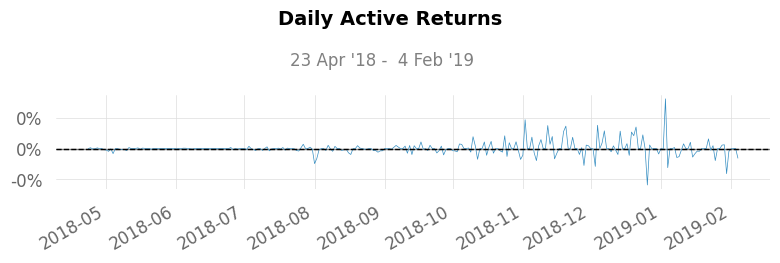

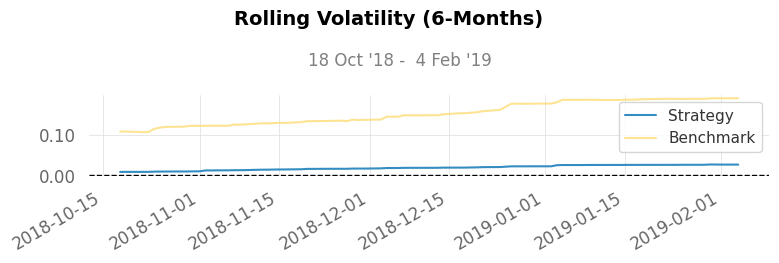

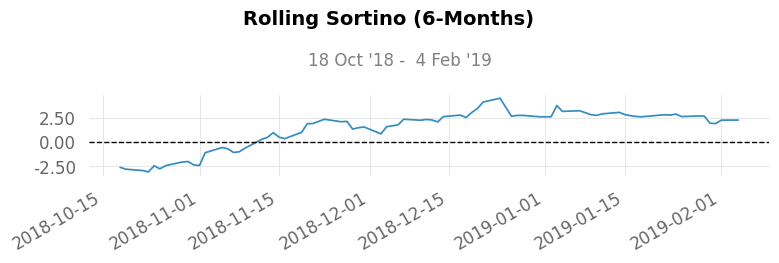

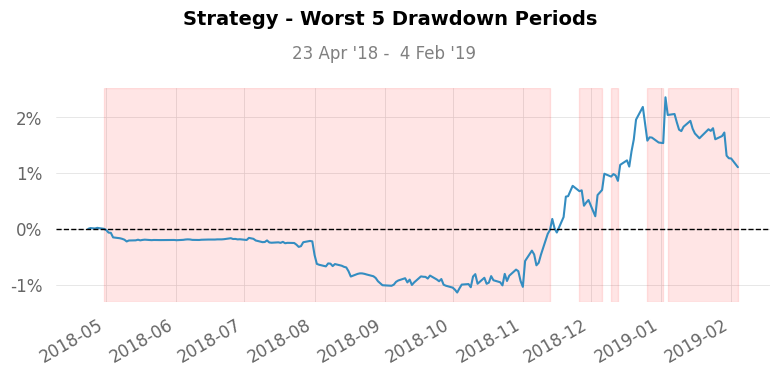

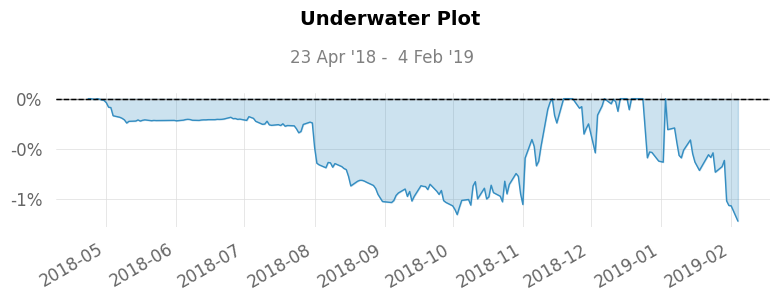

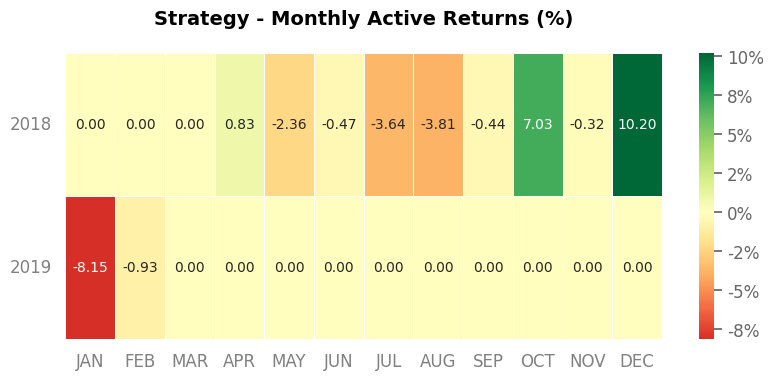

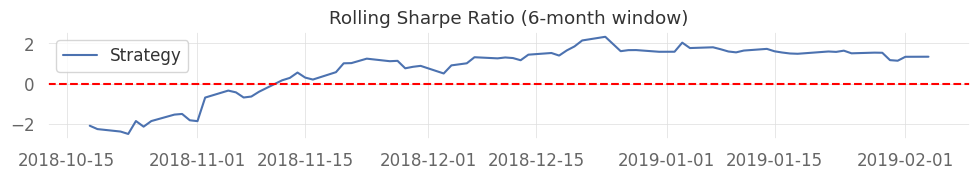

[*********************100%***********************]  1 of 1 completed


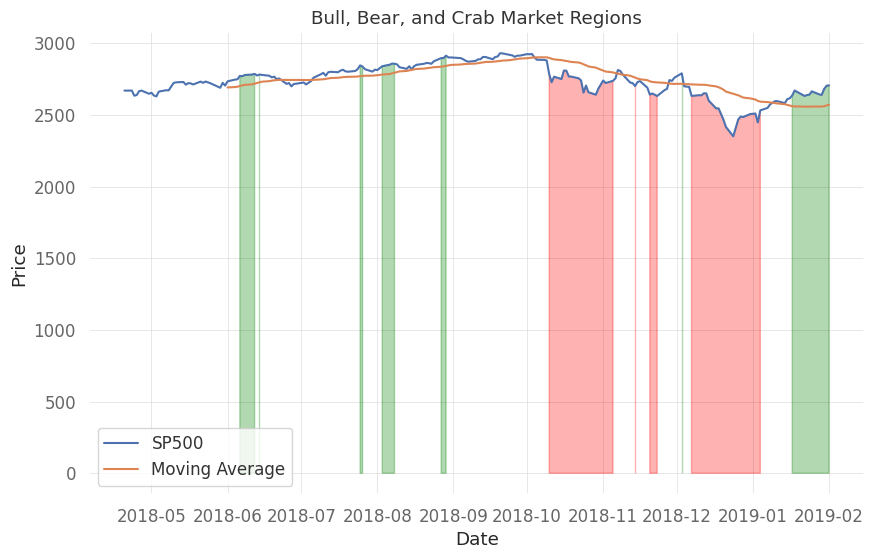

Total Trades: 29
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





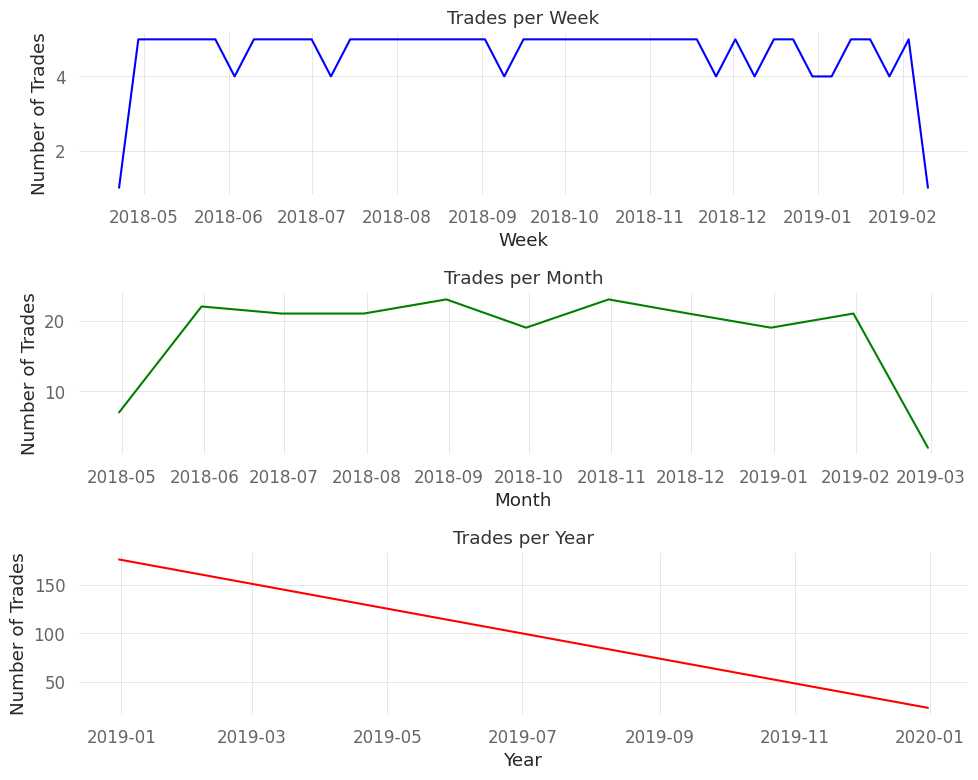

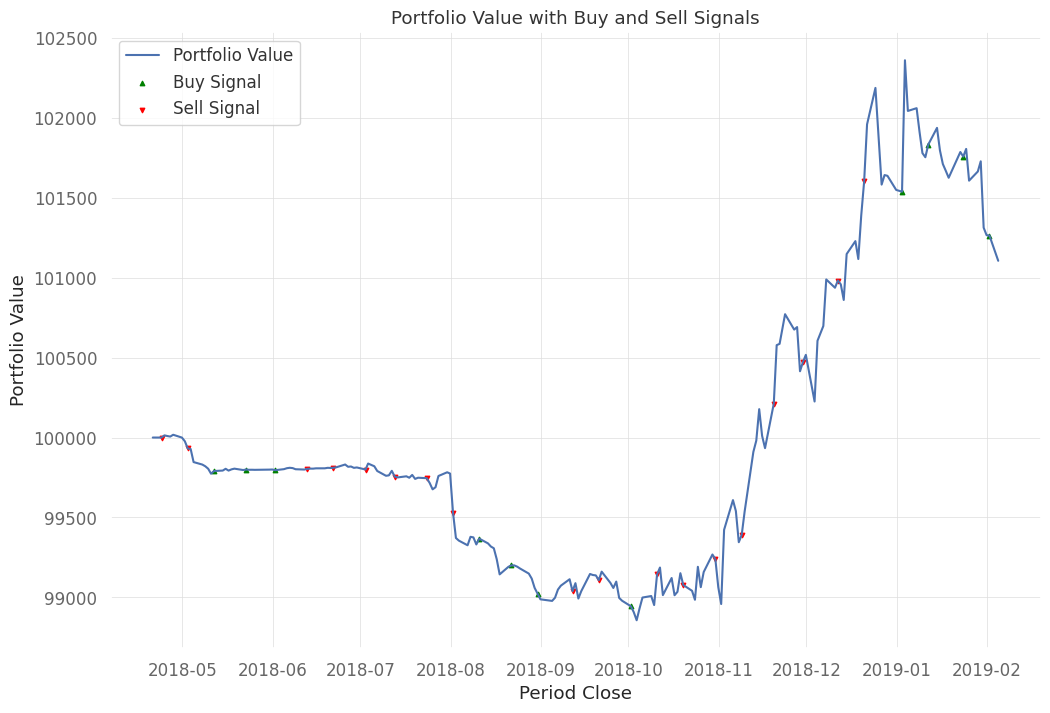

In [32]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)

### ETNA Moving Average

In [24]:
import pandas as pd

def initialize(context):
    # Load the price dataframe
    price_df = pd.read_csv('apple_by_MA_etna.csv', index_col=0, parse_dates=True)

    # Store the price dataframe
    context.price_df = price_df

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i = 0

def handle_data(context, data):
    asset = symbol('AAPL')

    pricedic = {}
    # Get the current date
    current_date = context.get_datetime().strftime('%Y-%m-%d')

    # Calculate the 7-day SMA of the predicted price for the current date
    predicted_price_history = context.price_df.loc[:current_date, 'target']
    sma_7_days = predicted_price_history.tail(7).mean()
    real_price_history = data.history(symbol('AAPL'), 'price', bar_count=7, frequency='1d')
    real_sma_7_days = real_price_history.mean()
    # Get the current price of AAPL
    

    if context.i%7 ==0:
        # Buy if current price is above the 7-day SMA, sell if below
        if real_sma_7_days > sma_7_days :
            order_value(symbol('AAPL'), 1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Buy AAPL')
        elif real_sma_7_days < sma_7_days :
            order_value(symbol('AAPL'), -1000)
            pricedic[asset] = (data.current(asset, 'price'))
            print('Sell AAPL')
    context.i = context.i + 1 
        
    record(PRI=pricedic)

In [25]:
start = '2018-04-20'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start),
    end=pd.Timestamp(end),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Buy AAPL
Sell AAPL
Buy AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Sell AAPL
Buy AAPL


[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-23   2018-04-23
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          63.92%       33.3%
Active Return              0.0%         -30.62%
CAGR﹪                     6.8%         3.9%

Sharpe                     0.55         0.8
Prob. Sharpe Ratio         89.36%       96.48%
Smart Sharpe               0.53         0.76
Sortino                    0.77         1.16
Smart Sortino              0.73         1.11
Sortino/√2                 0.54         0.82
Smart Sortino/√2           0.52         0.78
Omega                      1.17         1.17

Max Drawdown               -33.92%      -11.16%
Longest DD Days            541          539
Volatility (ann.)          21.42%       7.31%
R^2                        0.43         0.43
Information Ratio    

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-01-04  2023-01-05  2023-06-26   539    -11.164248        -10.398592
2  2020-09-02  2020-09-18  2020-12-24   114     -6.051273         -5.955774
3  2021-01-27  2021-03-08  2021-07-06   161     -5.845704         -5.093247
4  2020-02-13  2020-03-23  2020-06-02   111     -4.342665         -4.152981
5  2021-09-08  2021-10-04  2021-11-17    71     -3.627845         -3.275134

Slippage: 103.12400000000778
Slippage Lost: 20.412000000034283
Total Commission: 6.441000000000001


Average Long Exposure = 24072.33051761103
Average Short Exposure = -181.77187289433382
Average Net Leverage = 0.19744109473158947
Average Gross Leverage = 0.20105783719080902
Max Leverage = 0.3797157349647854



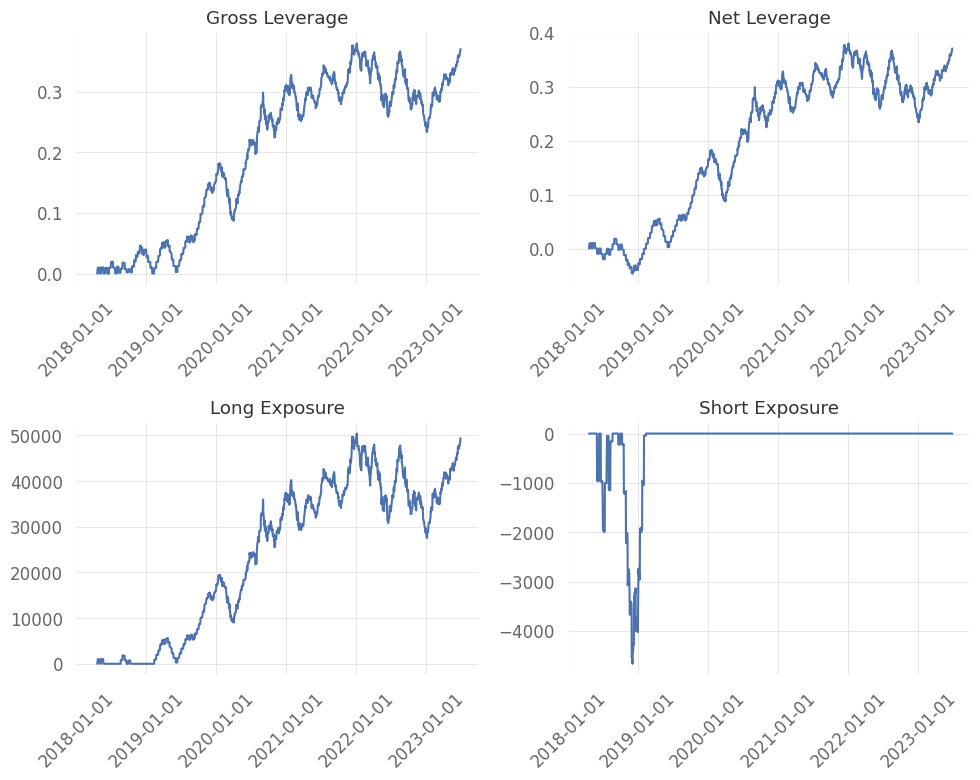

AAPL





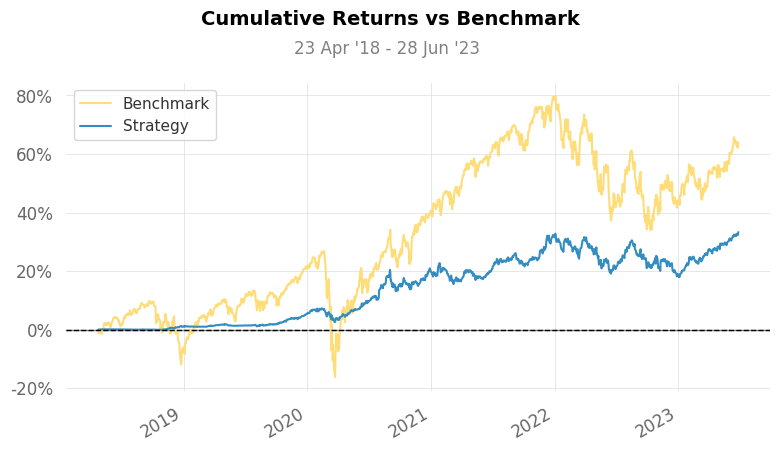

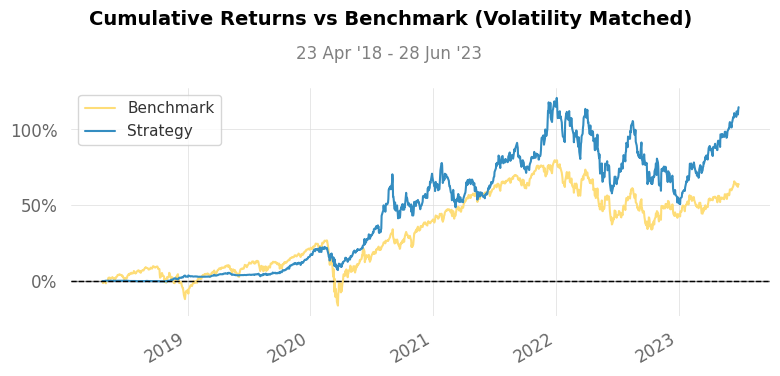

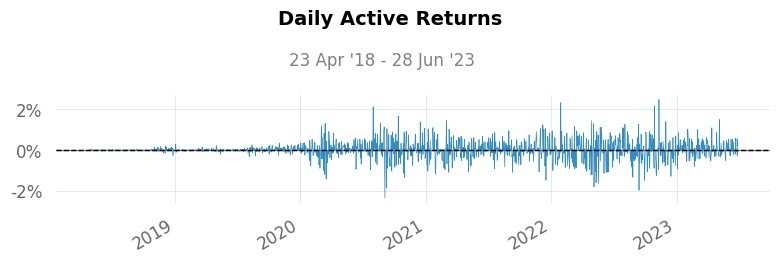

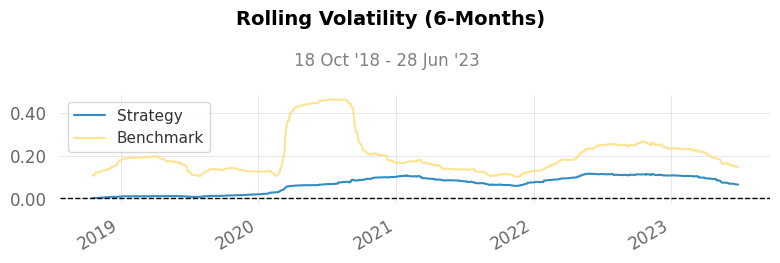

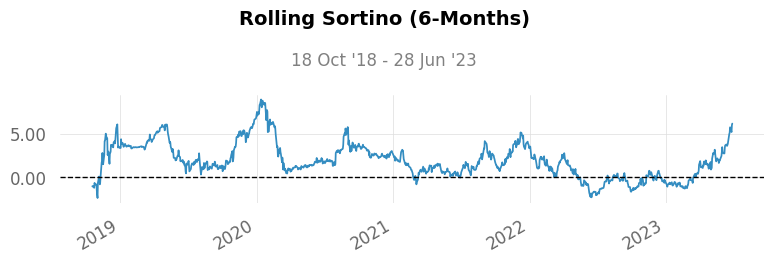

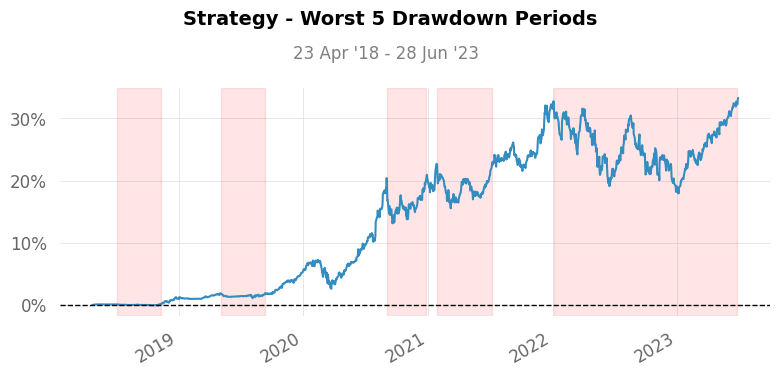

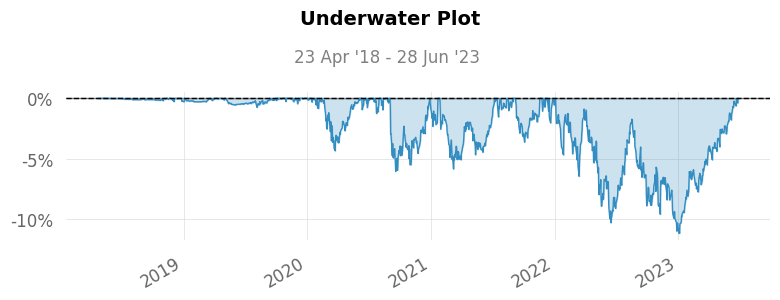

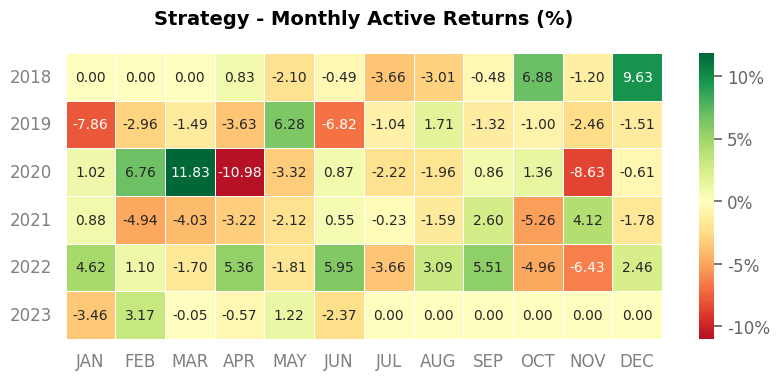

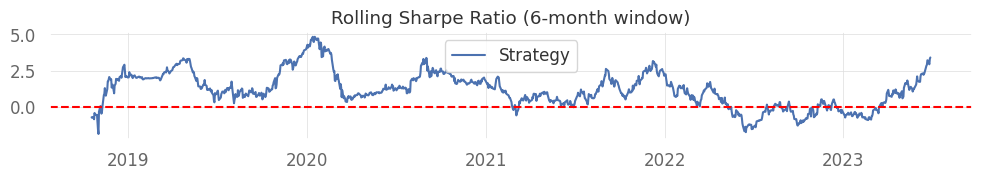

[*********************100%***********************]  1 of 1 completed


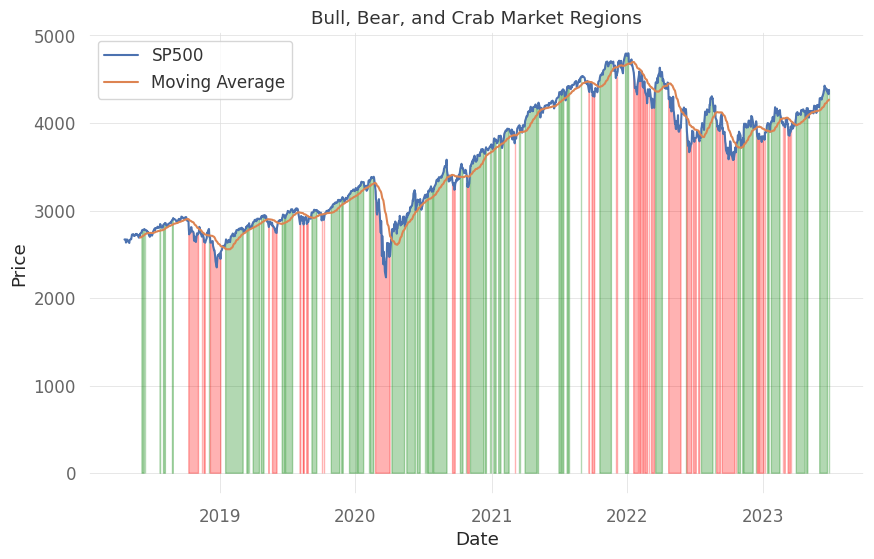

Total Trades: 187
Daily Trades: 1
Weekly Trades: 5
Monthly Trades: 21





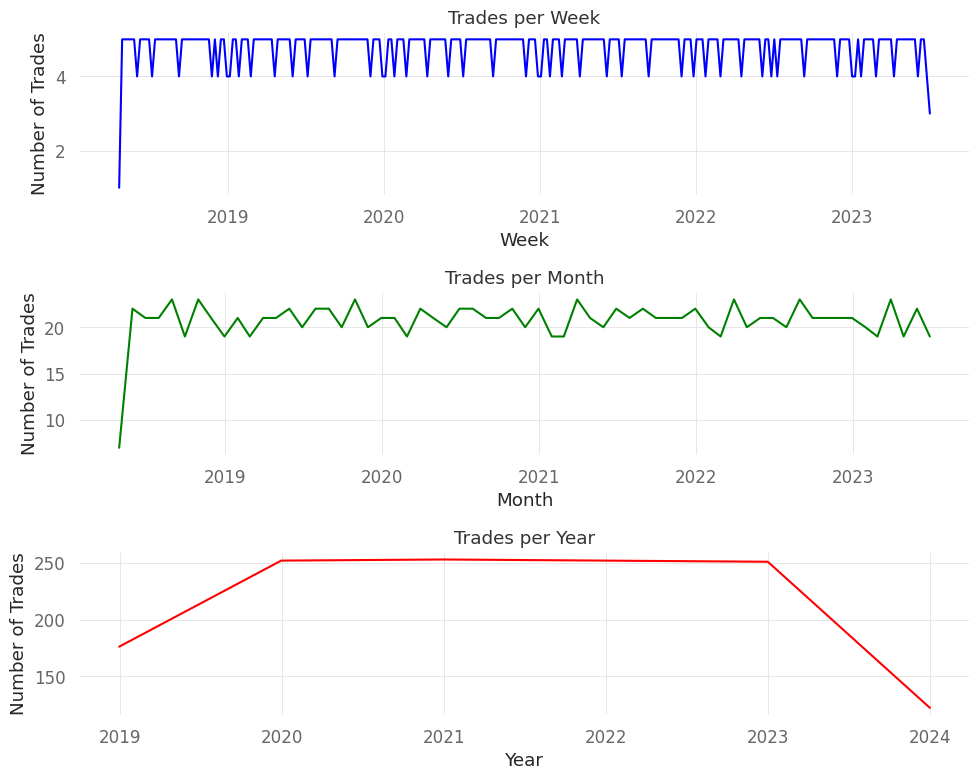

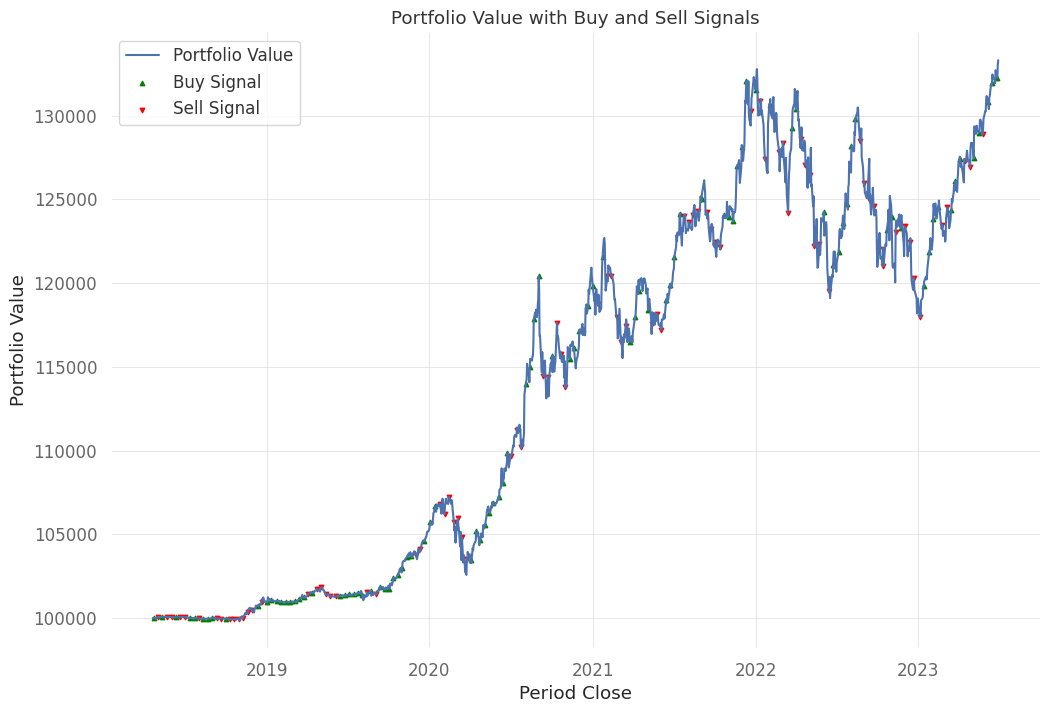

In [26]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)

### MA with 10 stocks

In [27]:
import pandas as pd

def initialize(context):
    # Load the price dataframe
    price_df = pd.read_csv('snp10_by_MA_etna.csv', index_col=0, parse_dates=True)

    # Store the price dataframe
    context.price_df = price_df

    # Set the trading frequency (e.g., daily)
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i = 0

def handle_data(context, data):
    # Get the list of assets
    assets = ['AAPL', 'ABBV', 'ADSK', 'ALGN', 'BIO', 'GRMN', 'INCY', 'MDT', 'MSFT', 'TEL']

    # Initialize dictionary to store prices for each asset
    pricedic = {}

    # Get the current date
    current_date = context.get_datetime().strftime('%Y-%m-%d')

    for asset in assets:
        # Calculate the 7-day SMA of the predicted price for the current date
        predicted_price_history = context.price_df.loc[:current_date, asset]
        sma_7_days = predicted_price_history.tail(7).mean()

        # Get the current price of the asset
        real_price_history = data.history(symbol(asset), 'price', bar_count=7, frequency='1d')
        real_sma_7_days = real_price_history.mean()

        if context.i % 7 == 0:
            # Buy if current price is above the 7-day SMA, sell if below
            if real_sma_7_days > sma_7_days:
                order_value(symbol(asset), 1000)
                pricedic[asset] = (data.current(symbol(asset), 'price'))
                print(f'Buy {asset}')
            elif real_sma_7_days < sma_7_days:
                order_value(symbol(asset), -1000)
                pricedic[asset] = (data.current(symbol(asset), 'price'))
                print(f'Sell {asset}')

    context.i = context.i + 1
        
    record(PRI=pricedic)


In [28]:
start = '2018-04-20'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start),
    end=pd.Timestamp(end),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Buy AAPL
Buy ABBV
Buy ADSK
Buy ALGN
Buy BIO
Buy GRMN
Buy INCY
Buy MDT
Buy MSFT
Buy TEL
Sell AAPL
Buy ABBV
Sell ADSK
Sell ALGN
Sell BIO
Buy GRMN
Sell INCY
Buy MDT
Sell MSFT
Sell TEL
Buy AAPL
Buy ABBV
Buy ADSK
Buy ALGN
Buy BIO
Buy GRMN
Buy INCY
Buy MDT
Buy MSFT
Buy TEL
Sell AAPL
Buy ABBV
Buy ADSK
Buy ALGN
Buy BIO
Buy GRMN
Buy INCY
Buy MDT
Buy MSFT
Buy TEL
Sell AAPL
Sell ABBV
Sell ADSK
Buy ALGN
Sell BIO
Buy GRMN
Buy INCY
Sell MDT
Buy MSFT
Sell TEL
Buy AAPL
Buy ABBV
Buy ADSK
Buy ALGN
Buy BIO
Buy GRMN
Buy INCY
Sell MDT
Buy MSFT
Buy TEL
Sell AAPL
Sell ABBV
Buy ADSK
Buy ALGN
Sell BIO
Sell GRMN
Buy INCY
Sell MDT
Sell MSFT
Buy TEL
Sell AAPL
Sell ABBV
Sell ADSK
Sell ALGN
Sell BIO
Sell GRMN
Sell INCY
Sell MDT
Sell MSFT
Sell TEL
Buy AAPL
Buy ABBV
Buy ADSK
Sell ALGN
Buy BIO
Buy GRMN
Buy INCY
Buy MDT
Buy MSFT
Buy TEL
Buy AAPL
Sell ABBV
Buy ADSK
Buy ALGN
Sell BIO
Buy GRMN
Sell INCY
Buy MDT
Buy MSFT
Buy TEL
Sell AAPL
Buy ABBV
Sell ADSK
Sell ALGN
Sell BIO
Sell GRMN
Sell INCY
Buy MDT
Sell MSFT
Buy TEL
B

[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2018-04-23   2018-04-23
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          63.92%       60.07%
Active Return              0.0%         -3.85%
CAGR﹪                     6.8%         6.47%

Sharpe                     0.55         0.59
Prob. Sharpe Ratio         89.36%       90.92%
Smart Sharpe               0.51         0.55
Sortino                    0.77         0.84
Smart Sortino              0.71         0.78
Sortino/√2                 0.54         0.59
Smart Sortino/√2           0.5          0.55
Omega                      1.11         1.11

Max Drawdown               -33.92%      -31.84%
Longest DD Days            541          548
Volatility (ann.)          21.42%       18.23%
R^2                        0.73         0.73
Information Ratio 

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2021-12-28  2022-11-09  2023-06-28   548    -31.836863        -30.754556
2  2020-02-13  2020-03-23  2020-06-02   111    -21.609762        -20.274307
3  2020-09-03  2020-09-23  2020-11-04    63     -9.959164         -9.685977
4  2019-05-01  2019-08-05  2019-10-29   182     -9.393453         -9.056490
5  2021-02-17  2021-03-08  2021-04-08    51     -8.757110         -7.520433

Slippage: 0
Slippage Lost: 0
Total Commission: 43.017


Average Long Exposure = 101812.74989739663
Average Short Exposure = -3368.157408882083
Average Net Leverage = 0.6955324598327594
Average Gross Leverage = 0.7460612929533753
Max Leverage = 1.0979465511622968



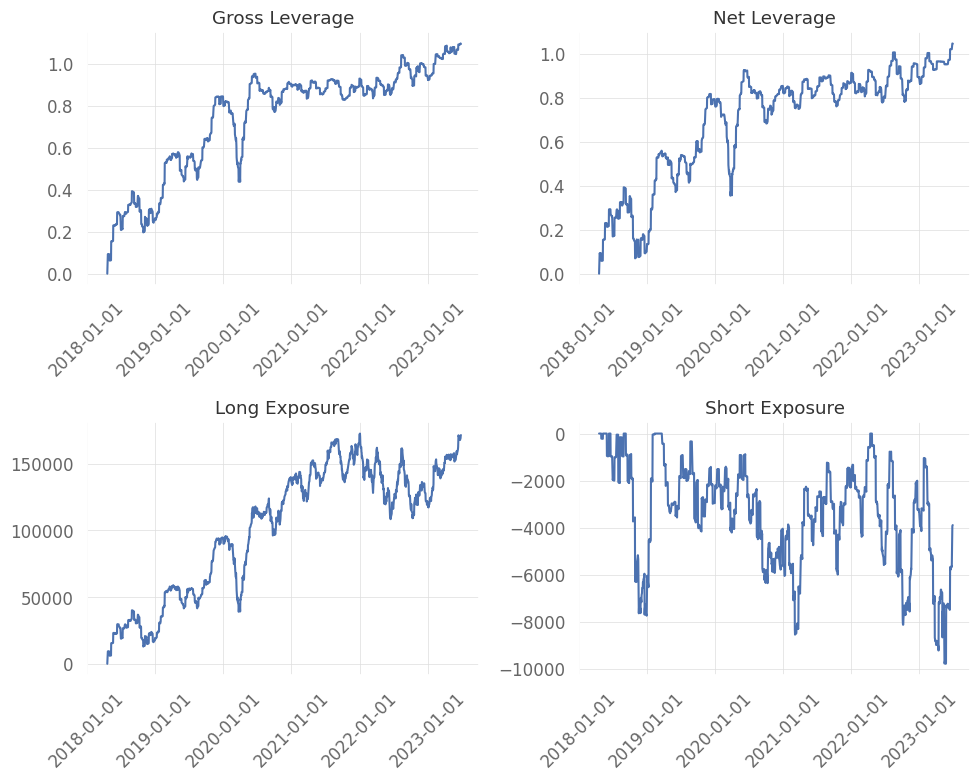

AAPL ABBV ADSK ALGN BIO GRMN INCY MDT MSFT TEL





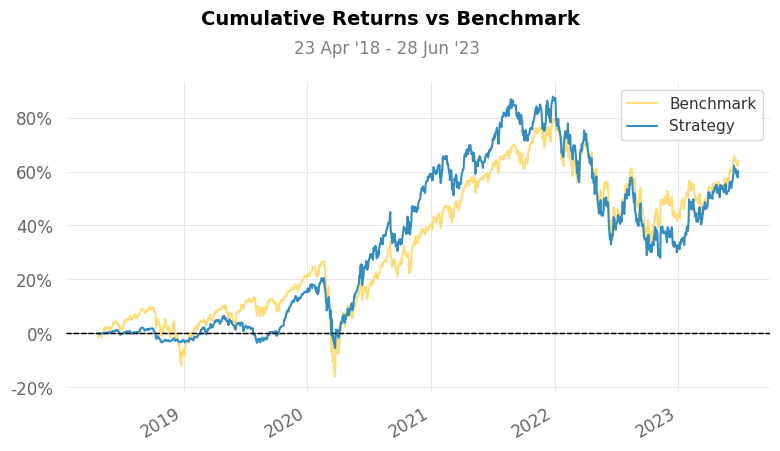

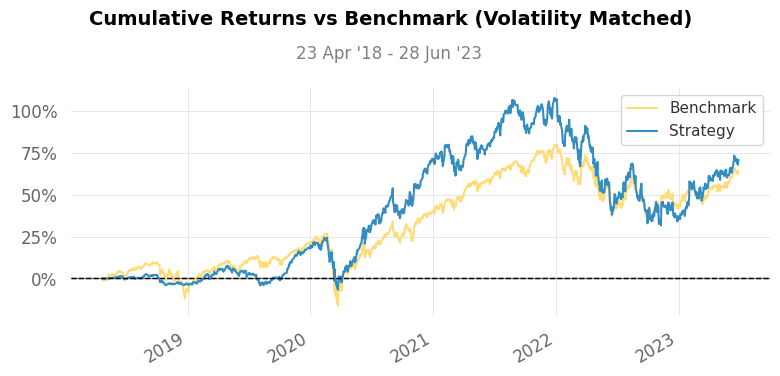

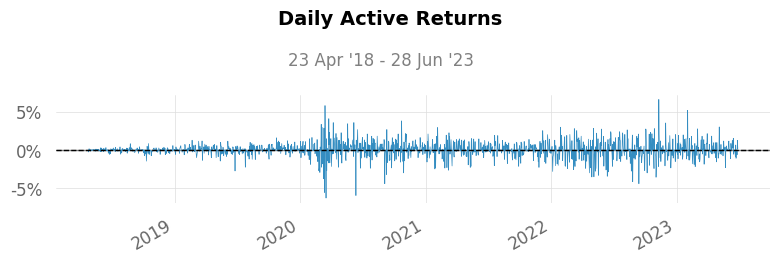

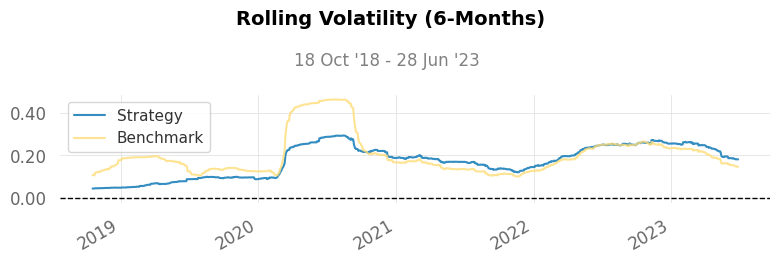

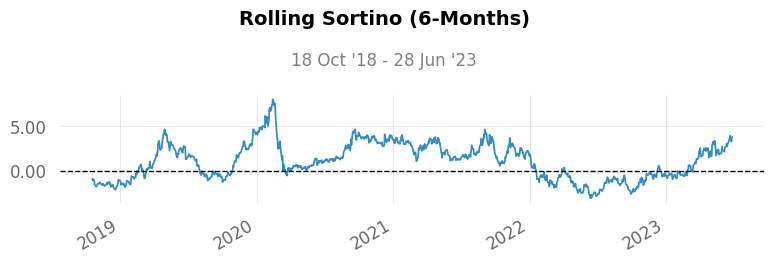

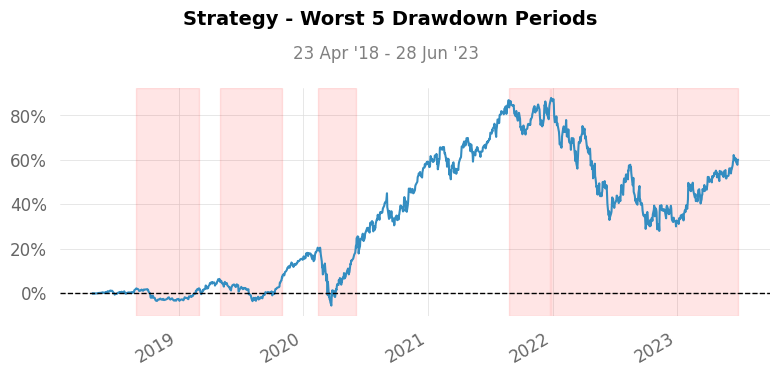

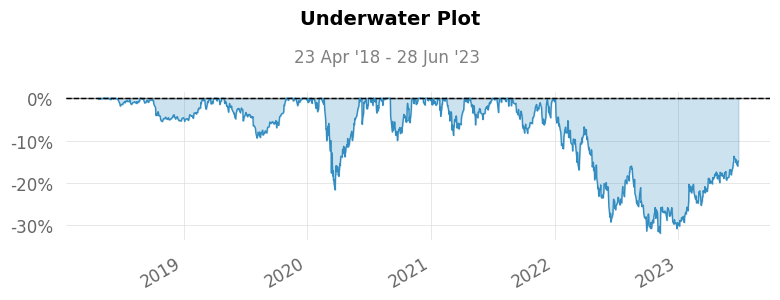

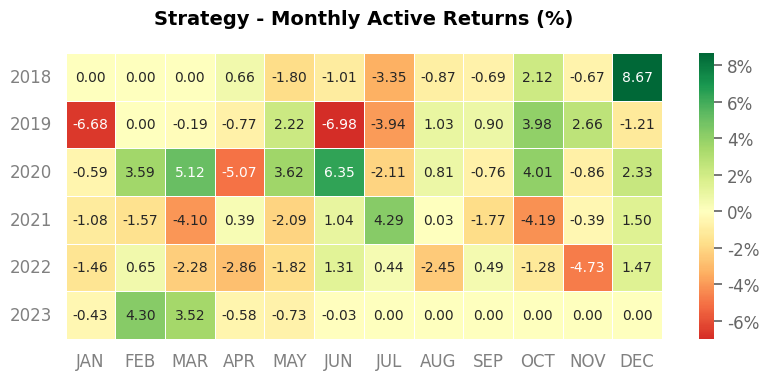

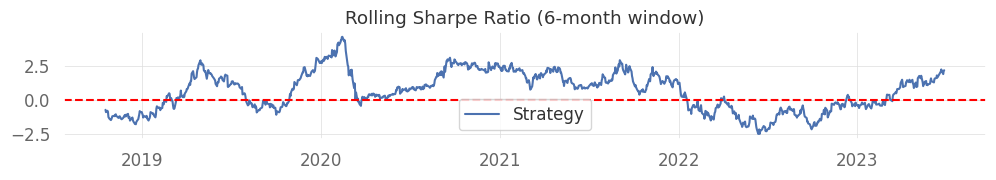

[*********************100%***********************]  1 of 1 completed


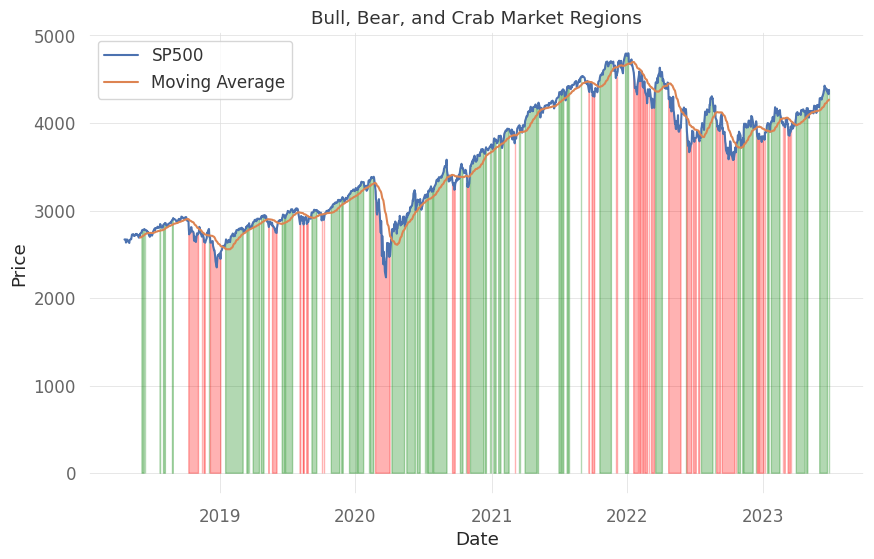

Total Trades: 1870
Daily Trades: 2
Weekly Trades: 10
Monthly Trades: 42





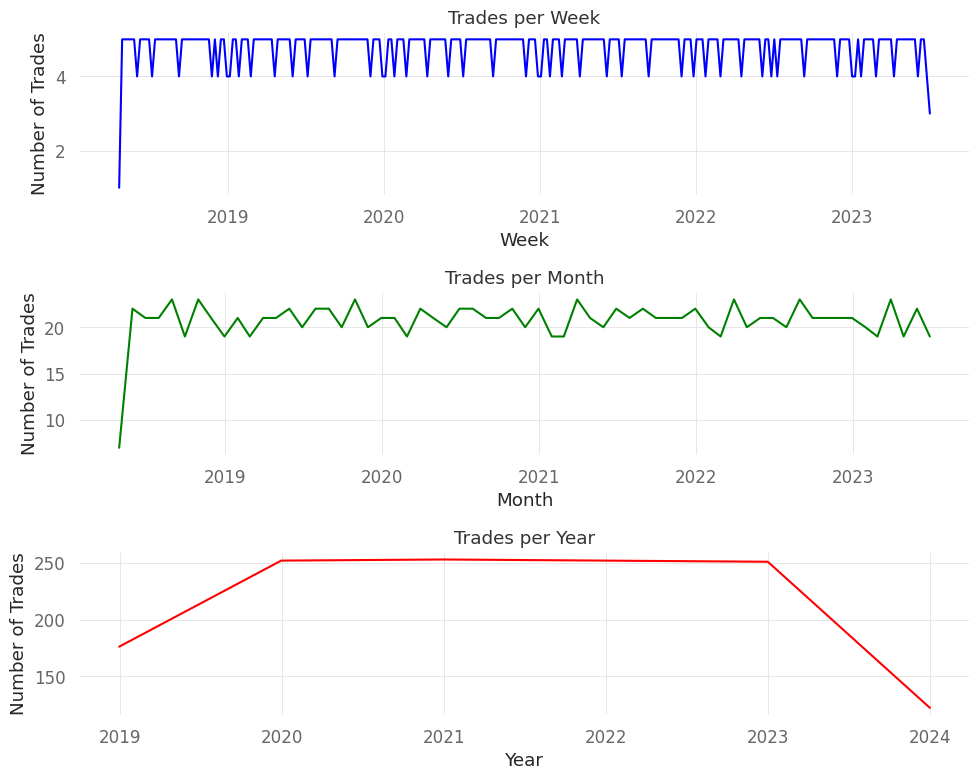

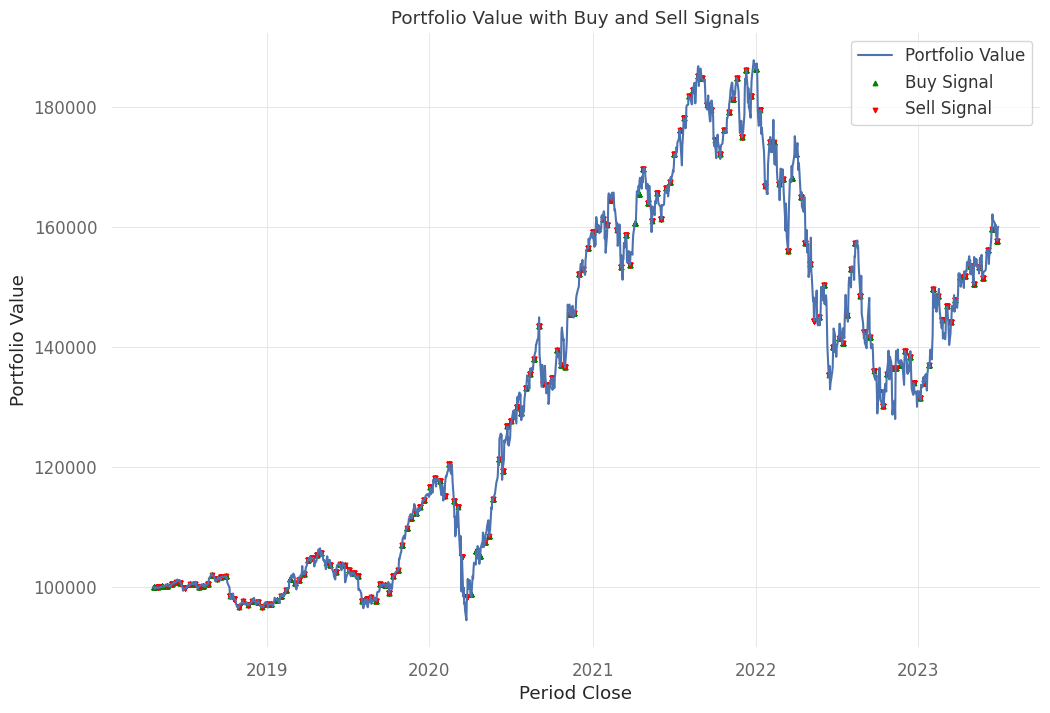

In [29]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)

# rough backtest

In [3]:
import pandas as pd

def initialize(context):
    context.trading_frequency = '1d'
    set_commission(PerShare(cost=0.003))
    set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))
    context.i = 0
    context.take_profit_long, context.take_profit_short  = 0.01, 0.01
    context.stop_loss_long, context.stop_loss_short = 0.02, 0.02

def handle_data(context, data):
    # Get the list of assets
    # assets = ['VTRS', 'DG', 'APA', 'GEHC', 'AAL', 'ABBV', 'AMZN']
    assets = ['META', 'MSFT', 'GOOGL', 'NFLX', 'AAPL', 'TSLA', 'AMZN']

    # Initialize dictionary to store prices for each asset
    pricedic = {}

    for asset in assets:
        # Get the current price of the asset
        real_price_history = data.history(symbol(asset), 'price', bar_count=15, frequency='1d')
        real_sma_7_days = real_price_history.mean()
        current_price = data.current(symbol(asset), 'price')
        
        # Buy if current price is above the 7-day SMA, sell if below
        if real_sma_7_days < current_price:
            order(symbol(asset), 100)
            pricedic[asset] = (data.current(symbol(asset), 'price'))
            print(f'Buy {asset}')
        elif real_sma_7_days > current_price:
            order(symbol(asset), -100)
            pricedic[asset] = (data.current(symbol(asset), 'price'))
            print(f'Sell {asset}')
            
        for asset in context.portfolio.positions:
            current_price = data.current(asset, 'price')
            cost_basis = context.portfolio.positions[asset].cost_basis
            amount = context.portfolio.positions[asset].amount
            if amount > 0:
                if current_price >= cost_basis * (1 + context.take_profit_long):
                    order_target_percent(asset, 0)
                    print('take_proft')
                    
                elif current_price <= cost_basis * (1 - context.stop_loss_long):
                    order_target_percent(asset, 0)
                    print('stop_loss')
                  
            elif amount < 0:
                if current_price >= cost_basis * (1 + context.stop_loss_short):
                    order_target_percent(asset, 0)
                    print('stop_loss')
                 
                elif current_price <= cost_basis *  (1 - context.take_profit_short):
                    order_target_percent(asset, 0)
                    print('take_proft')

    record(PRI=pricedic)


In [4]:
start = '2018-04-20'
end = '2023-06-28'
capital_base = 100000

results = run_algorithm(
    start=pd.Timestamp(start),
    end=pd.Timestamp(end),
    initialize=initialize,
    handle_data=handle_data,
    capital_base=capital_base,
    trading_calendar=calendar,
    bundle=bundle,
    data_frequency='daily')

Buy META
Buy MSFT
Buy GOOGL
Buy NFLX
Sell AAPL
Sell TSLA
Buy AMZN
Buy META
Buy MSFT
Buy GOOGL
Buy NFLX
Sell AAPL
Sell TSLA
Buy AMZN
Sell META
stop_loss
Sell MSFT
stop_loss
Sell GOOGL
stop_loss
Sell NFLX
stop_loss
Sell AAPL
stop_loss
Sell TSLA
stop_loss
Sell AMZN
stop_loss
Sell META
stop_loss
stop_loss
Sell MSFT
stop_loss
stop_loss
Sell GOOGL
stop_loss
stop_loss
Sell NFLX
stop_loss
stop_loss
Sell AAPL
stop_loss
stop_loss
Sell TSLA
stop_loss
stop_loss
Sell AMZN
stop_loss
stop_loss
Buy META
Buy MSFT
Sell GOOGL
Buy NFLX
Sell AAPL
Sell TSLA
Buy AMZN
Buy META
stop_loss
Buy MSFT
stop_loss
Sell GOOGL
stop_loss
Sell NFLX
stop_loss
Sell AAPL
stop_loss
Buy TSLA
stop_loss
Buy AMZN
stop_loss
Buy META
Sell MSFT
Sell GOOGL
Sell NFLX
Sell AAPL
Buy TSLA
Buy AMZN
Buy META
stop_loss
take_proft
Buy MSFT
stop_loss
take_proft
Sell GOOGL
stop_loss
take_proft
Sell NFLX
stop_loss
take_proft
Sell AAPL
stop_loss
take_proft
Buy TSLA
stop_loss
take_proft
Buy AMZN
stop_loss
take_proft
Buy META
take_proft
Sell MSFT


[*********************100%***********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ------------------
Start Period               2018-04-23   2018-04-23
End Period                 2023-06-28   2023-06-28
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          63.92%       -1,207,416,932.17%
Active Return              0.0%         -1207416996.09%
CAGR﹪                     6.8%         777.5%

Sharpe                     0.55         0.28
Prob. Sharpe Ratio         89.36%       72.72%
Smart Sharpe               0.55         0.28
Sortino                    0.77         0.35
Smart Sortino              0.76         0.35
Sortino/√2                 0.54         0.25
Smart Sortino/√2           0.54         0.25
Omega                      1.16         1.16

Max Drawdown               -33.92%      -4257.91%
Longest DD Days            541          1486
Volatility (ann.)          21.42%       945.39%
R^2                        0.

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2019-06-04  2023-05-01  2023-06-28  1486  -4257.914930      -4129.386682
2  2018-05-23  2018-05-31  2018-06-05    14   -601.670967       -348.601630
3  2018-05-17  2018-05-18  2018-05-18     2   -231.480882        -70.156118
4  2018-05-08  2018-05-09  2018-05-10     3   -105.982885        -37.279814
5  2019-01-04  2019-02-06  2019-05-17   134   -104.428953       -104.322015

Slippage: 0
Slippage Lost: 0
Total Commission: 1301282426.1000001


Average Long Exposure = 1251025225883.6353
Average Short Exposure = -1318872410823.5486
Average Net Leverage = -2.265446216679378
Average Gross Leverage = 3.895395479987095
Max Leverage = 674.4012240297303



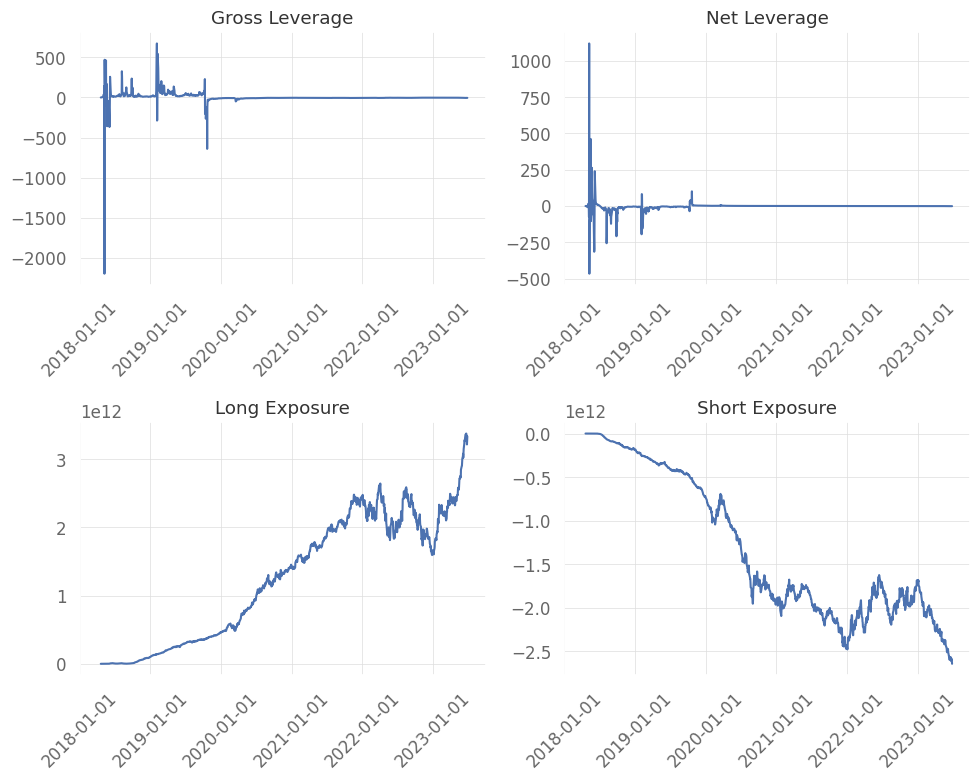

AAPL AMZN GOOGL META MSFT NFLX TSLA





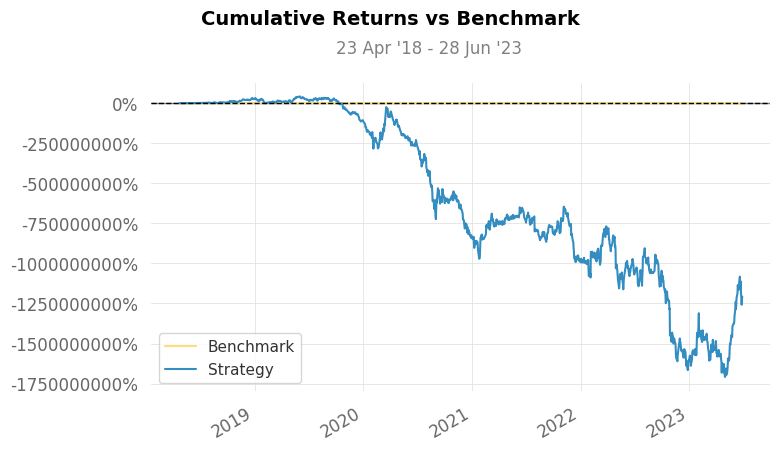

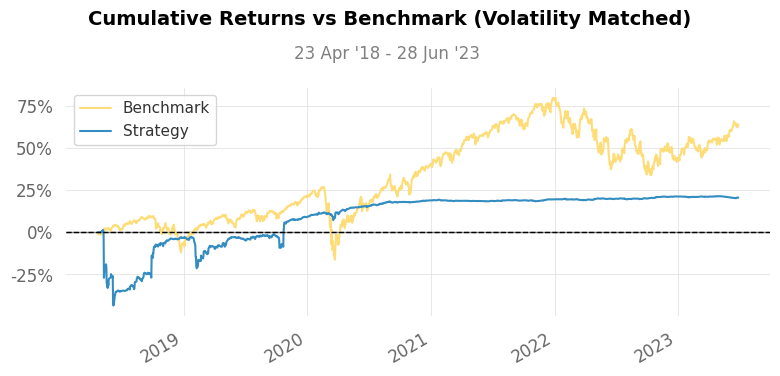

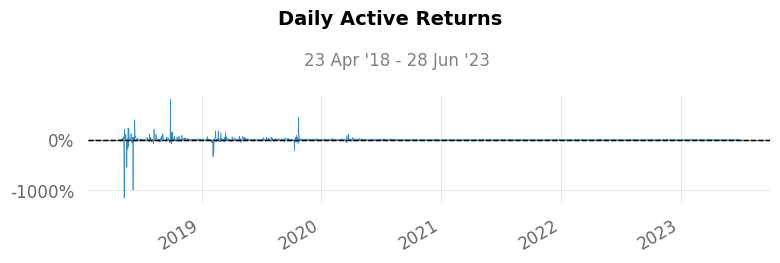

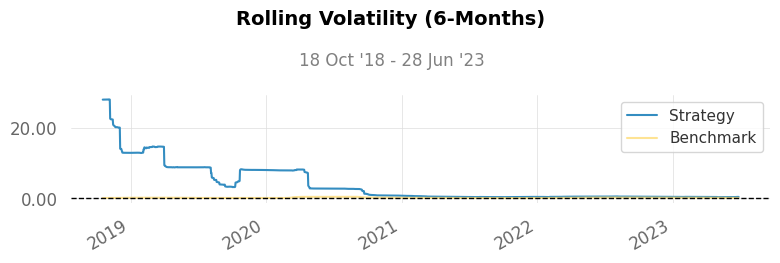

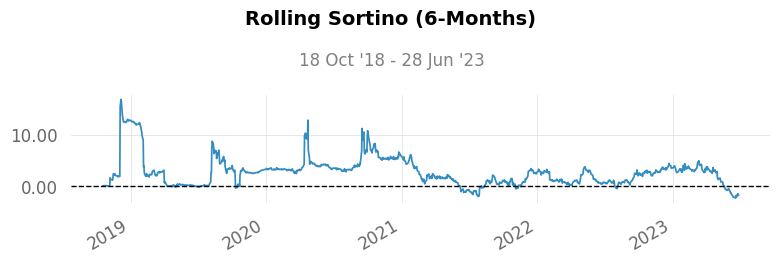

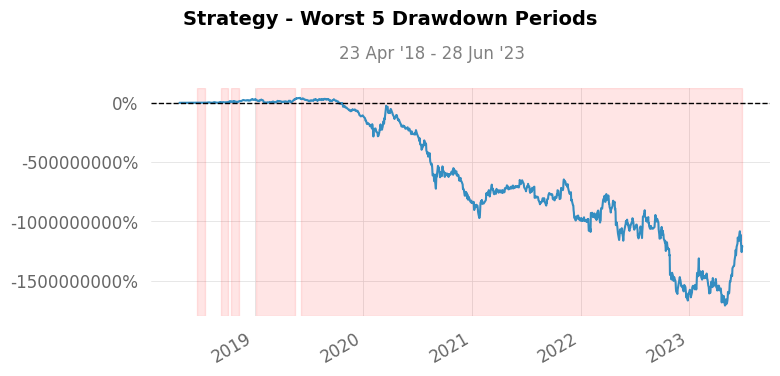

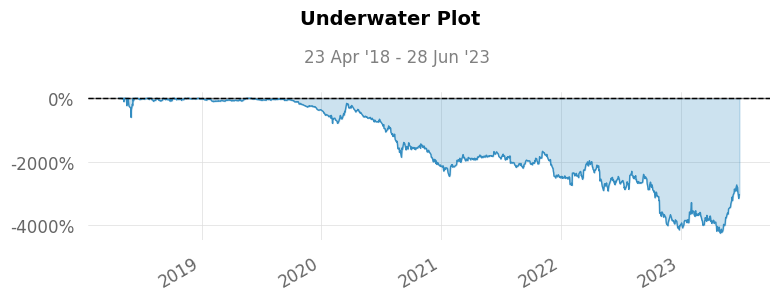

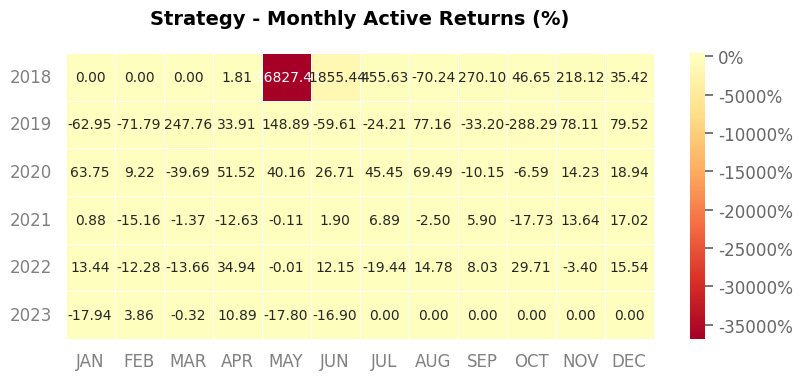

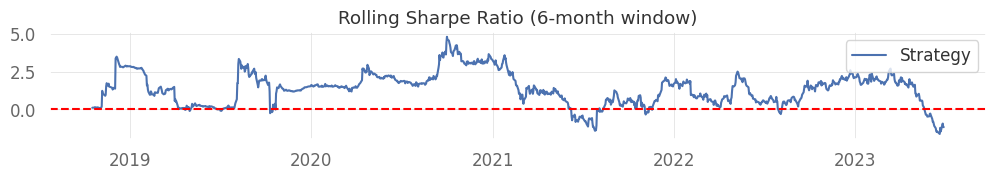

[*********************100%***********************]  1 of 1 completed


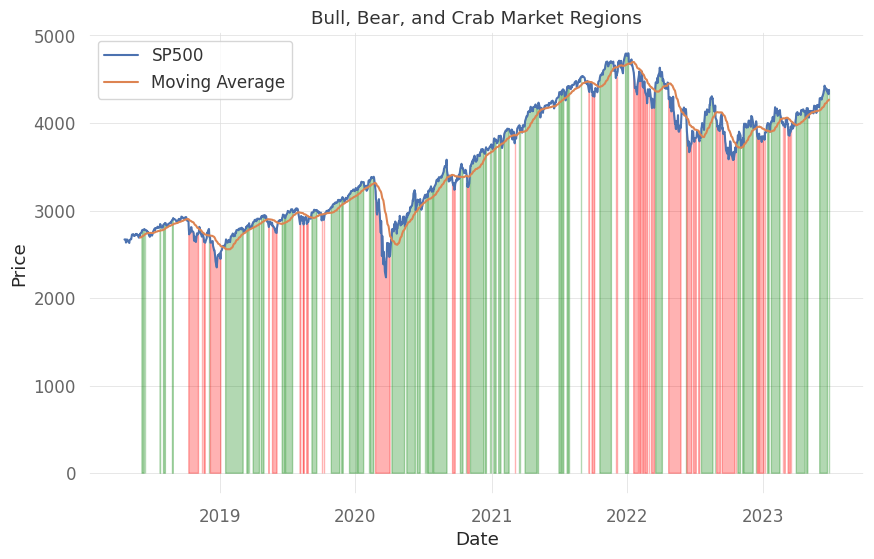

Total Trades: 10687
Daily Trades: 9
Weekly Trades: 45
Monthly Trades: 189





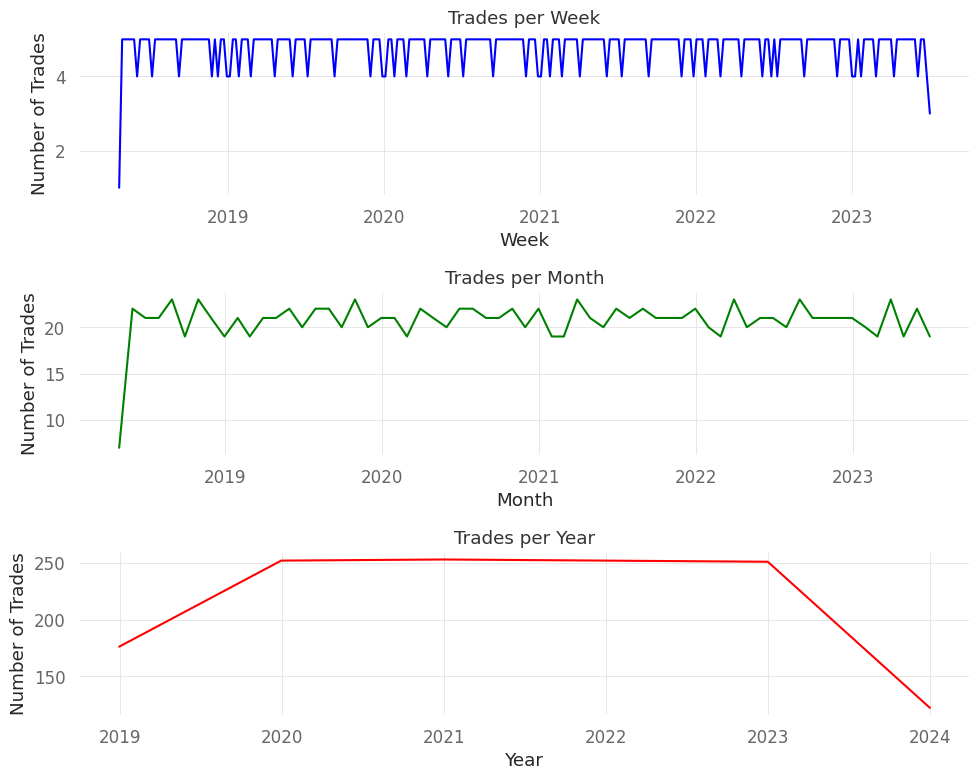

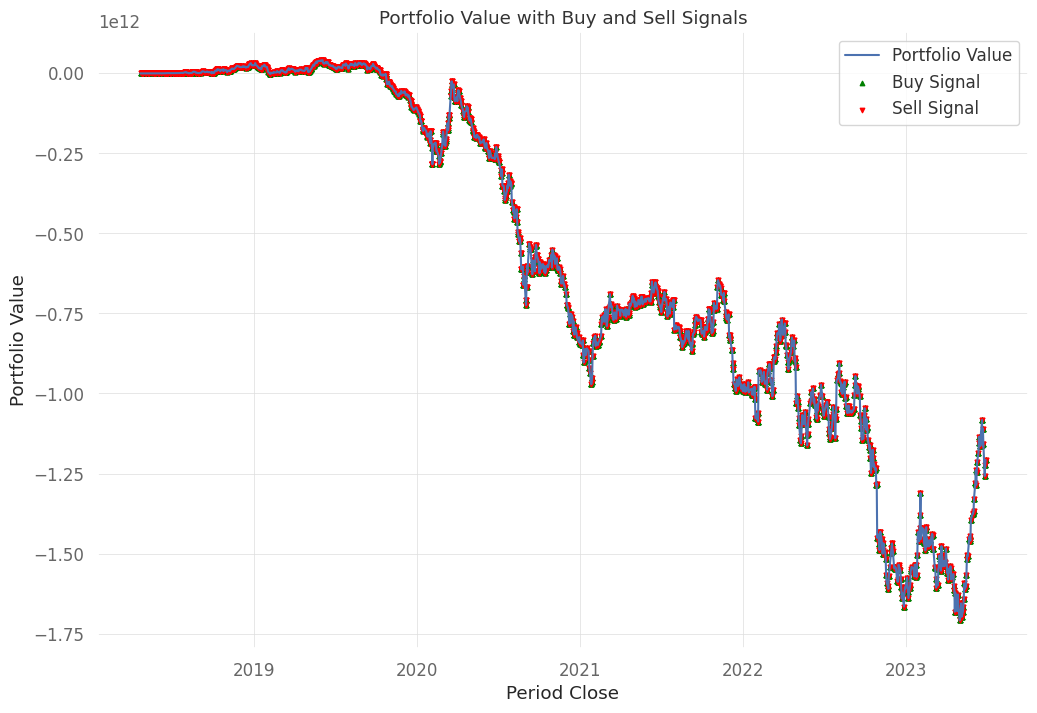

In [5]:
start = results.index[0]
end = results.index[-1]
benchmark = yf.download('^GSPC', start=start, end=end)['Adj Close'].pct_change()
results.index = pd.to_datetime(results.index).tz_convert(None)
results.index = benchmark.index    
qs.reports.full(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4), df = results)